In [1]:
# Importation des biblioth√®ques n√©cessaires
import numpy as np
import pandas as pd
import os
import gc
import re
import time
import json
import mlflow
import mlflow.sklearn
from mlflow.tracking import MlflowClient
from mlflow.models.signature import infer_signature
import matplotlib.pyplot as plt
import seaborn as sns
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from xgboost import callback
from lightgbm import early_stopping, log_evaluation
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, roc_curve, confusion_matrix, make_scorer
from sklearn.model_selection import KFold, StratifiedKFold, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope
import shap
from IPython.display import display, FileLink, HTML
import warnings
import joblib
import subprocess

C:\Users\guigo\anaconda3\envs\projet-scoring\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

D√©marrage d'une session de suivi MLFlow

In [3]:
mlflow.set_tracking_uri("file:///C:/Users/guigo/Documents/FORMATION/Alternance/Projet 7/mlruns")
experiment = mlflow.set_experiment("P7_Scoring")

print(f"Exp√©rience actuelle : {experiment.name} (ID: {experiment.experiment_id})")
print(f"Les runs seront stock√©s ici : {mlflow.get_tracking_uri()}")

2025/04/24 20:40:56 INFO mlflow.tracking.fluent: Experiment with name 'P7_Scoring' does not exist. Creating a new experiment.


Exp√©rience actuelle : P7_Scoring (ID: 719211569620934913)
Les runs seront stock√©s ici : file:///C:/Users/guigo/Documents/FORMATION/Alternance/Projet 7/mlruns


# 1.D√©finition des fonctions

In [4]:
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

# Fonction pour calculer les valeurs manquantes
def missing_values_table(df):
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(columns={0: 'Valeurs manquantes', 1: '% du total'})
    mis_val_table_ren_columns = mis_val_table_ren_columns[mis_val_table_ren_columns.iloc[:, 1] != 0] \
        .sort_values('% du total', ascending=False).round(1)
    print(f"Le dataframe contient {df.shape[1]} colonnes.\n"
          f"Il y a {mis_val_table_ren_columns.shape[0]} colonnes qui ont des valeurs manquantes.")
    return mis_val_table_ren_columns

# Fonction d'analyse exploratoire pour une table
def analyze_table(df, table_name):
    print(f"\n=== Analyse pour {table_name} ===")
    print(f"Taille : {df.shape}")
    print("Aper√ßu des premi√®res lignes :")
    display(df.head())
    print("\n--- Distribution des types de colonnes :")
    print(df.dtypes.value_counts())
    print("\n--- Valeurs manquantes :")
    missing_values = missing_values_table(df)
    print(missing_values.head(10))

# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category=True):
    original_columns = list(df.columns)
    # S√©lection des colonnes cat√©gorielles
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    # Forcer la conversion en cha√Æne pour √™tre s√ªr que get_dummies fonctionne bien
    for col in categorical_columns:
        df[col] = df[col].astype(str)
    # Appliquer get_dummies
    df = pd.get_dummies(df, columns=categorical_columns, dummy_na=nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns


# Fonction pour cr√©er des features polynomiales
def create_polynomial_features(df_train, df_test, features):
    # Cr√©ation des datasets pour les features polynomiales
    poly_train = df_train[features]
    poly_test = df_test[features]

    # Imputation des valeurs manquantes
    imputer = SimpleImputer(strategy='median')
    poly_train = imputer.fit_transform(poly_train)
    poly_test = imputer.transform(poly_test)

    # G√©n√©ration des features polynomiales (degree=2)
    poly_transformer = PolynomialFeatures(degree=2)
    poly_train = poly_transformer.fit_transform(poly_train)
    poly_test = poly_transformer.transform(poly_test)

    # R√©cup√©ration des noms des nouvelles features
    feature_names = poly_transformer.get_feature_names_out(features)

    # Conversion en DataFrame
    poly_train = pd.DataFrame(poly_train, columns=feature_names)
    poly_test = pd.DataFrame(poly_test, columns=feature_names)

    # Ajout de l'identifiant SK_ID_CURR pour fusion avec les datasets principaux
    poly_train['SK_ID_CURR'] = df_train['SK_ID_CURR']
    poly_test['SK_ID_CURR'] = df_test['SK_ID_CURR']

    return poly_train, poly_test


# Fonction pour afficher l'importance des features
def display_importances(feature_importance_df_):
    cols = (
        feature_importance_df_[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:40]
        .index
    )
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(
        x="importance",
        y="feature",
        data=best_features.sort_values(by="importance", ascending=False),
    )
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances01.png')

# Fonction pour calculer l'indice d'information mutuelle
def calculate_mutual_information(df, target_col, n_top_features=80):
    """
    Calcule l'indice d'information mutuelle entre chaque colonne d'un DataFrame et une colonne cible.
    Retourne les colonnes les plus pertinentes.
    """
    # Identification des colonnes num√©riques
    num_cols = df.select_dtypes(include=['float64', 'int64', 'float32', 'int32']).columns
    num_cols = [col for col in num_cols if col != target_col]  # Exclure la cible

    # Calcul de l'information mutuelle
    mi_scores = mutual_info_classif(df[num_cols], df[target_col], discrete_features=False, random_state=42)

    # Cr√©ation d'un DataFrame avec les scores
    mi_scores_df = pd.DataFrame({'Feature': num_cols, 'MI_Score': mi_scores})
    mi_scores_df = mi_scores_df.sort_values(by='MI_Score', ascending=False).reset_index(drop=True)

    print(f"Top {n_top_features} features bas√©es sur l'information mutuelle :")
    print(mi_scores_df.head(n_top_features))

    # Retour des n meilleures features
    return mi_scores_df['Feature'].head(n_top_features).tolist()

def reduce_mem_usage(df):
    """R√©duit l'utilisation m√©moire du DataFrame en changeant les types num√©riques."""
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min >= np.iinfo(np.int8).min and c_max <= np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min >= np.iinfo(np.int16).min and c_max <= np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min >= np.iinfo(np.int32).min and c_max <= np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
            else:
                df[col] = df[col].astype(np.float32)
    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    return df

def kfold_xgboost(df, num_folds=3, stratified=False, debug=False):
    """
    Entra√Æne un mod√®le XGBoost avec validation crois√©e (KFold ou StratifiedKFold)
    et retourne un DataFrame contenant l'importance des features.

    Arguments :
        df : DataFrame contenant les donn√©es d'entra√Ænement et de test.
        num_folds : Nombre de folds pour la validation crois√©e.
        stratified : Si True, utilise StratifiedKFold.
        debug : Si True, n'enregistre pas le fichier de soumission.

    Retourne :
        feature_importance_df : DataFrame avec l'importance des features.
    """
    # S√©paration des donn√©es d'entra√Ænement et de test
    train_df = df[df['TARGET'].notnull()].copy()
    test_df = df[df['TARGET'].isnull()].copy()
    print(f"Starting XGBoost. Train shape: {train_df.shape}, test shape: {test_df.shape}")

    # Lib√©ration de la m√©moire
    del df
    gc.collect()

    # Nettoyage des valeurs infinies : remplace np.inf et -np.inf par np.nan
    train_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    test_df.replace([np.inf, -np.inf], np.nan, inplace=True)

    # Choix de la m√©thode de validation crois√©e
    if stratified:
        folds = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=1001)
    else:
        folds = KFold(n_splits=num_folds, shuffle=True, random_state=1001)

    # Initialisation des tableaux pour les pr√©dictions et l'importance
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()

    # Liste des features √† utiliser (excluant TARGET et les identifiants)
    feats = [f for f in train_df.columns if f not in ['TARGET', 'SK_ID_CURR', 'SK_ID_BUREAU', 'SK_ID_PREV', 'index']]

    # Nettoyage des noms de colonnes (remplace les caract√®res sp√©ciaux par '_')
    train_df = train_df.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '_', x))
    test_df = test_df.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '_', x))
    feats = [re.sub('[^A-Za-z0-9_]+', '_', f) for f in feats]

    # Boucle sur les folds de validation crois√©e
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

        # Initialisation du classifieur XGBoost avec support GPU (CUDA)
        clf = XGBClassifier(
            n_estimators=10000,
            learning_rate=0.02,
            max_depth=6,
            reg_alpha=0.02,
            reg_lambda=0.04,
            colsample_bytree=0.8,
            subsample=0.8,
            tree_method='hist',  
            predictor='cpu_predictor',  
            n_jobs=-1,  # Utiliser tous les c≈ìurs du processeur
            use_label_encoder=False,
            eval_metric='auc',
            verbosity=0,
            early_stopping_rounds=100      
        )

        # Entra√Ænement du mod√®le avec early stopping
        clf.fit(
            train_x, train_y,
            eval_set=[(valid_x, valid_y)],
            verbose=True
        )

        # Pr√©dictions sur le set de validation et sur le set de test
        oof_preds[valid_idx] = clf.predict_proba(valid_x)[:, 1]
        sub_preds += clf.predict_proba(test_df[feats])[:, 1] / folds.n_splits

        # Extraction de l'importance des features pour ce fold
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

        print(f'Fold {n_fold + 1} AUC : {roc_auc_score(valid_y, oof_preds[valid_idx]):.6f}')

        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()

    # Score global AUC sur le set d'entra√Ænement
    print(f'Full AUC score {roc_auc_score(train_df["TARGET"], oof_preds):.6f}')

    # G√©n√©ration du fichier de soumission si n√©cessaire
    if not debug:
        test_df['TARGET'] = sub_preds
        test_df[['SK_ID_CURR', 'TARGET']].to_csv('submission.csv', index=False)

    # Affichage de l'importance des features 
    display_importances(feature_importance_df)

    return feature_importance_df

def select_features_with_sampling(df, target_col='TARGET', n_features=40, sample_size=50000):
    from sklearn.model_selection import train_test_split
    from sklearn.ensemble import RandomForestClassifier
    import pandas as pd

    # Suppression des lignes o√π TARGET est NaN
    df = df.dropna(subset=[target_col])  

    # S'assurer que sample_size n'est pas plus grand que la taille du DataFrame
    sample_size = min(sample_size, len(df))

    # √âchantillonnage stratifi√© pour pr√©server la distribution de TARGET
    df_sample, _ = train_test_split(
        df, 
        train_size=sample_size, 
        stratify=df[target_col], 
        random_state=42
    )

    print(f"Utilisation d'un √©chantillon de {len(df_sample)} lignes pour la s√©lection des features")

    X = df_sample.drop(['TARGET', 'SK_ID_CURR'], axis=1)
    y = df_sample[target_col]

    # Remplacement des valeurs infinies par NaN
    X.replace([np.inf, -np.inf], np.nan, inplace=True)

    # Remplacement des NaN par la m√©diane de chaque colonne
    X.fillna(X.median(), inplace=True)

    # Entra√Ænement du mod√®le RandomForest
    model = RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        min_samples_leaf=10,
        n_jobs=-1,
        random_state=42
    )

    model.fit(X, y)

    # Cr√©ation d'un DataFrame d'importance
    importance_df = pd.DataFrame({
        'feature': X.columns,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)

    # S√©lection des meilleures caract√©ristiques
    selected_features = importance_df.head(n_features)['feature'].tolist()

    return selected_features, importance_df

# 2.Chargement des donn√©es

In [5]:
# Chemin vers le dossier contenant les datasets
dataset_dir = r"C:\Users\guigo\Documents\FORMATION\Alternance\Projet 7\Donn√©es P7"

# Chargement des fichiers CSV en utilisant os.path.join pour g√©rer correctement les s√©parateurs
df_train = pd.read_csv(os.path.join(dataset_dir, "application_train.csv"))
df_test = pd.read_csv(os.path.join(dataset_dir, "application_test.csv"))
df_bureau = pd.read_csv(os.path.join(dataset_dir, "bureau.csv"))
df_bureau_balance = pd.read_csv(os.path.join(dataset_dir, "bureau_balance.csv"))
df_previous = pd.read_csv(os.path.join(dataset_dir, "previous_application.csv"))
df_credit_card = pd.read_csv(os.path.join(dataset_dir, "credit_card_balance.csv"))
df_pos_cash = pd.read_csv(os.path.join(dataset_dir, "POS_CASH_balance.csv"))
df_installments = pd.read_csv(os.path.join(dataset_dir, "installments_payments.csv"))
print("Fichiers charg√©s avec succ√®s !")

Fichiers charg√©s avec succ√®s !


# 3.Analyse exploratoire / Feature engineering

## Exploration des tables

J'affiche ici des informations essentielles sur les tables, telles que la taille, un aper√ßu des premi√®res lignes, la distribution des types de donn√©es, ainsi que les d√©tails des valeurs manquantes.

In [6]:
analyze_table(df_train, "application_train")
analyze_table(df_test, "application_test")
analyze_table(df_bureau, "bureau")
analyze_table(df_bureau_balance, "bureau_balance")
analyze_table(df_previous, "previous_application")
analyze_table(df_credit_card, "credit_card_balance")
analyze_table(df_pos_cash, "POS_CASH_balance")
analyze_table(df_installments, "installments_payments")


=== Analyse pour application_train ===
Taille : (307511, 122)
Aper√ßu des premi√®res lignes :


SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   AMT_GOODS_PRICE NAME_TYPE_SUITE NAME_INCOME_TYPE  \
0         351000.0   Unaccompanied          Working   
1        1129500.0          Family    State servant   
2         135000.0   Unaccompanied          Working   
3         297000.0   Unaccompanied          Working   
4         513000.0   Unaccompanied          Working   

             NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
0  Secondary / secondary special  Single / not married  House / apartment   
1               Higher education               Married  House / apartment   
2  Secondary / secondary special  Single / not married  House / apartment   
3  Secondary / secondary special        Civil marriage  House / apartment   
4  Secondary / secondary special  Single / not married  House / apartment   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                    0.018801       -9461           -637            -3648.0   
1                    0.003541      -16765          -1188            -1186.0   
2                    0.010032      -19046           -225            -4260.0   
3                    0.008019      -19005          -3039            -9833.0   
4                    0.028663      -19932          -3038            -4311.0   

   DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0            -2120          NaN           1               1                0   
1             -291          NaN           1               1                0   
2            -2531         26.0           1               1                1   
3            -2437          NaN           1               1                0   
4            -3458          NaN           1               1                0   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  \
0                 1           1           0        Laborers              1.0   
1                 1           1           0      Core staff              2.0   
2                 1           1           0        Laborers              1.0   
3                 1           0           0        Laborers              2.0   
4                 1           0           0      Core staff              1.0   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
0                     2                            2   
1                     1                            1   
2                     2                            2   
3                     2                            2   
4                     2                            2   

  WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  \
0                  WEDNESDAY                       10   
1                     MONDAY                       11   
2                     MONDAY                        9   
3                  WEDNESDAY                       17   
4                   THURSDAY                       11   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           0   
1                           0                           0   
2                        


--- Distribution des types de colonnes :
float64    65
int64      41
object     16
Name: count, dtype: int64

--- Valeurs manquantes :
Le dataframe contient 122 colonnes.
Il y a 67 colonnes qui ont des valeurs manquantes.
                          Valeurs manquantes  % du total
COMMONAREA_MEDI                       214865        69.9
COMMONAREA_AVG                        214865        69.9
COMMONAREA_MODE                       214865        69.9
NONLIVINGAPARTMENTS_MEDI              213514        69.4
NONLIVINGAPARTMENTS_MODE              213514        69.4
NONLIVINGAPARTMENTS_AVG               213514        69.4
FONDKAPREMONT_MODE                    210295        68.4
LIVINGAPARTMENTS_MODE                 210199        68.4
LIVINGAPARTMENTS_MEDI                 210199        68.4
LIVINGAPARTMENTS_AVG                  210199        68.4

=== Analyse pour application_test ===
Taille : (48744, 121)
Aper√ßu des premi√®res lignes :


SK_ID_CURR NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
0      100001         Cash loans           F            N               Y   
1      100005         Cash loans           M            N               Y   
2      100013         Cash loans           M            Y               Y   
3      100028         Cash loans           F            N               Y   
4      100038         Cash loans           M            Y               N   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0          135000.0    568800.0      20560.5         450000.0   
1             0           99000.0    222768.0      17370.0         180000.0   
2             0          202500.0    663264.0      69777.0         630000.0   
3             2          315000.0   1575000.0      49018.5        1575000.0   
4             1          180000.0    625500.0      32067.0         625500.0   

  NAME_TYPE_SUITE NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
0   Unaccompanied          Working               Higher education   
1   Unaccompanied          Working  Secondary / secondary special   
2             NaN          Working               Higher education   
3   Unaccompanied          Working  Secondary / secondary special   
4   Unaccompanied          Working  Secondary / secondary special   

  NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  REGION_POPULATION_RELATIVE  \
0            Married  House / apartment                    0.018850   
1            Married  House / apartment                    0.035792   
2            Married  House / apartment                    0.019101   
3            Married  House / apartment                    0.026392   
4            Married  House / apartment                    0.010032   

   DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  \
0      -19241          -2329            -5170.0             -812          NaN   
1      -18064          -4469            -9118.0            -1623          NaN   
2      -20038          -4458            -2175.0            -3503          5.0   
3      -13976          -1866            -2000.0            -4208          NaN   
4      -13040          -2191            -4000.0            -4262         16.0   

   FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  \
0           1               1                0                 1           0   
1           1               1                0                 1           0   
2           1               1                0                 1           0   
3           1               1                0                 1           1   
4           1               1                1                 1           0   

   FLAG_EMAIL     OCCUPATION_TYPE  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
0           1                 NaN              2.0                     2   
1           0  Low-skill Laborers              2.0                     2   
2           0             Drivers              2.0                     2   
3           0         Sales staff              4.0                     2   
4           0                 NaN              3.0                     2   

   REGION_RATING_CLIENT_W_CITY WEEKDAY_APPR_PROCESS_START  \
0                            2                    TUESDAY   
1                            2                     FRIDAY   
2                            2                     MONDAY   
3                            2                  WEDNESDAY   
4                            2                     FRIDAY   

   HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  \
0                       18                           0   
1                        9                           0   
2                       14                           0   
3                       11                           0   
4                        5                           0   

   REG_REGION_NOT_WORK_REGION  LIVE_REGION_NOT_WORK_REGION  \
0                   


--- Distribution des types de colonnes :
float64    65
int64      40
object     16
Name: count, dtype: int64

--- Valeurs manquantes :
Le dataframe contient 121 colonnes.
Il y a 64 colonnes qui ont des valeurs manquantes.
                          Valeurs manquantes  % du total
COMMONAREA_MODE                        33495        68.7
COMMONAREA_MEDI                        33495        68.7
COMMONAREA_AVG                         33495        68.7
NONLIVINGAPARTMENTS_MEDI               33347        68.4
NONLIVINGAPARTMENTS_AVG                33347        68.4
NONLIVINGAPARTMENTS_MODE               33347        68.4
FONDKAPREMONT_MODE                     32797        67.3
LIVINGAPARTMENTS_MODE                  32780        67.2
LIVINGAPARTMENTS_MEDI                  32780        67.2
LIVINGAPARTMENTS_AVG                   32780        67.2

=== Analyse pour bureau ===
Taille : (1716428, 17)
Aper√ßu des premi√®res lignes :


SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT  \
0      215354       5714462        Closed      currency 1         -497   
1      215354       5714463        Active      currency 1         -208   
2      215354       5714464        Active      currency 1         -203   
3      215354       5714465        Active      currency 1         -203   
4      215354       5714466        Active      currency 1         -629   

   CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  \
0                   0               -153.0             -153.0   
1                   0               1075.0                NaN   
2                   0                528.0                NaN   
3                   0                  NaN                NaN   
4                   0               1197.0                NaN   

   AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  \
0                     NaN                   0         91323.0   
1                     NaN                   0        225000.0   
2                     NaN                   0        464323.5   
3                     NaN                   0         90000.0   
4                 77674.5                   0       2700000.0   

   AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE  \
0                  0.0                   NaN                     0.0   
1             171342.0                   NaN                     0.0   
2                  NaN                   NaN                     0.0   
3                  NaN                   NaN                     0.0   
4                  NaN                   NaN                     0.0   

       CREDIT_TYPE  DAYS_CREDIT_UPDATE  AMT_ANNUITY  
0  Consumer credit                -131          NaN  
1      Credit card                 -20          NaN  
2  Consumer credit                 -16          NaN  
3      Credit card                 -16          NaN  
4  Consumer credit                 -21          NaN


--- Distribution des types de colonnes :
float64    8
int64      6
object     3
Name: count, dtype: int64

--- Valeurs manquantes :
Le dataframe contient 17 colonnes.
Il y a 7 colonnes qui ont des valeurs manquantes.
                        Valeurs manquantes  % du total
AMT_ANNUITY                        1226791        71.5
AMT_CREDIT_MAX_OVERDUE             1124488        65.5
DAYS_ENDDATE_FACT                   633653        36.9
AMT_CREDIT_SUM_LIMIT                591780        34.5
AMT_CREDIT_SUM_DEBT                 257669        15.0
DAYS_CREDIT_ENDDATE                 105553         6.1
AMT_CREDIT_SUM                          13         0.0

=== Analyse pour bureau_balance ===
Taille : (27299925, 3)
Aper√ßu des premi√®res lignes :


SK_ID_BUREAU  MONTHS_BALANCE STATUS
0       5715448               0      C
1       5715448              -1      C
2       5715448              -2      C
3       5715448              -3      C
4       5715448              -4      C


--- Distribution des types de colonnes :
int64     2
object    1
Name: count, dtype: int64

--- Valeurs manquantes :
Le dataframe contient 3 colonnes.
Il y a 0 colonnes qui ont des valeurs manquantes.
Empty DataFrame
Columns: [Valeurs manquantes, % du total]
Index: []

=== Analyse pour previous_application ===
Taille : (1670214, 37)
Aper√ßu des premi√®res lignes :


SK_ID_PREV  SK_ID_CURR NAME_CONTRACT_TYPE  AMT_ANNUITY  AMT_APPLICATION  \
0     2030495      271877     Consumer loans     1730.430          17145.0   
1     2802425      108129         Cash loans    25188.615         607500.0   
2     2523466      122040         Cash loans    15060.735         112500.0   
3     2819243      176158         Cash loans    47041.335         450000.0   
4     1784265      202054         Cash loans    31924.395         337500.0   

   AMT_CREDIT  AMT_DOWN_PAYMENT  AMT_GOODS_PRICE WEEKDAY_APPR_PROCESS_START  \
0     17145.0               0.0          17145.0                   SATURDAY   
1    679671.0               NaN         607500.0                   THURSDAY   
2    136444.5               NaN         112500.0                    TUESDAY   
3    470790.0               NaN         450000.0                     MONDAY   
4    404055.0               NaN         337500.0                   THURSDAY   

   HOUR_APPR_PROCESS_START FLAG_LAST_APPL_PER_CONTRACT  \
0                       15                           Y   
1                       11                           Y   
2                       11                           Y   
3                        7                           Y   
4                        9                           Y   

   NFLAG_LAST_APPL_IN_DAY  RATE_DOWN_PAYMENT  RATE_INTEREST_PRIMARY  \
0                       1                0.0               0.182832   
1                       1                NaN                    NaN   
2                       1                NaN                    NaN   
3                       1                NaN                    NaN   
4                       1                NaN                    NaN   

   RATE_INTEREST_PRIVILEGED NAME_CASH_LOAN_PURPOSE NAME_CONTRACT_STATUS  \
0                  0.867336                    XAP             Approved   
1                       NaN                    XNA             Approved   
2                       NaN                    XNA             Approved   
3                       NaN                    XNA             Approved   
4                       NaN                Repairs              Refused   

   DAYS_DECISION      NAME_PAYMENT_TYPE CODE_REJECT_REASON  NAME_TYPE_SUITE  \
0            -73  Cash through the bank                XAP              NaN   
1           -164                    XNA                XAP    Unaccompanied   
2           -301  Cash through the bank                XAP  Spouse, partner   
3           -512  Cash through the bank                XAP              NaN   
4           -781  Cash through the bank                 HC              NaN   

  NAME_CLIENT_TYPE NAME_GOODS_CATEGORY NAME_PORTFOLIO NAME_PRODUCT_TYPE  \
0         Repeater              Mobile            POS               XNA   
1         Repeater                 XNA           Cash            x-sell   
2         Repeater                 XNA           Cash            x-sell   
3         Repeater                 XNA           Cash            x-sell   
4         Repeater                 XNA           Cash           walk-in   

              CHANNEL_TYPE  SELLERPLACE_AREA NAME_SELLER_INDUSTRY  \
0             Country-wide                35         Connectivity   
1           Contact center                -1                  XNA   
2  Credit and cash offices                -1                  XNA   
3  Credit and cash offices                -1                  XNA   
4  Credit and cash offices                -1                  XNA   

   CNT_PAYMENT NAME_YIELD_GROUP       PRODUCT_COMBINATION  DAYS_FIRST_DRAWING  \
0         12.0           middle  POS mobile with interest            365243.0   
1         36.0       low_action          Cash X-Sell: low            365243.0   
2         12.0             high         Cash X-Sell: high            365243.0   
3         12.0           middle       Cash X-Sell: middle            365243.0   
4         24.0             high         Cash Street: high                 NaN   

   D


--- Distribution des types de colonnes :
object     16
float64    15
int64       6
Name: count, dtype: int64

--- Valeurs manquantes :
Le dataframe contient 37 colonnes.
Il y a 16 colonnes qui ont des valeurs manquantes.
                           Valeurs manquantes  % du total
RATE_INTEREST_PRIMARY                 1664263        99.6
RATE_INTEREST_PRIVILEGED              1664263        99.6
AMT_DOWN_PAYMENT                       895844        53.6
RATE_DOWN_PAYMENT                      895844        53.6
NAME_TYPE_SUITE                        820405        49.1
DAYS_FIRST_DRAWING                     673065        40.3
DAYS_FIRST_DUE                         673065        40.3
DAYS_LAST_DUE_1ST_VERSION              673065        40.3
DAYS_LAST_DUE                          673065        40.3
DAYS_TERMINATION                       673065        40.3

=== Analyse pour credit_card_balance ===
Taille : (3840312, 23)
Aper√ßu des premi√®res lignes :


SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  AMT_BALANCE  \
0     2562384      378907              -6       56.970   
1     2582071      363914              -1    63975.555   
2     1740877      371185              -7    31815.225   
3     1389973      337855              -4   236572.110   
4     1891521      126868              -1   453919.455   

   AMT_CREDIT_LIMIT_ACTUAL  AMT_DRAWINGS_ATM_CURRENT  AMT_DRAWINGS_CURRENT  \
0                   135000                       0.0                 877.5   
1                    45000                    2250.0                2250.0   
2                   450000                       0.0                   0.0   
3                   225000                    2250.0                2250.0   
4                   450000                       0.0               11547.0   

   AMT_DRAWINGS_OTHER_CURRENT  AMT_DRAWINGS_POS_CURRENT  \
0                         0.0                     877.5   
1                         0.0                       0.0   
2                         0.0                       0.0   
3                         0.0                       0.0   
4                         0.0                   11547.0   

   AMT_INST_MIN_REGULARITY  AMT_PAYMENT_CURRENT  AMT_PAYMENT_TOTAL_CURRENT  \
0                 1700.325               1800.0                     1800.0   
1                 2250.000               2250.0                     2250.0   
2                 2250.000               2250.0                     2250.0   
3                11795.760              11925.0                    11925.0   
4                22924.890              27000.0                    27000.0   

   AMT_RECEIVABLE_PRINCIPAL  AMT_RECIVABLE  AMT_TOTAL_RECEIVABLE  \
0                     0.000          0.000                 0.000   
1                 60175.080      64875.555             64875.555   
2                 26926.425      31460.085             31460.085   
3                224949.285     233048.970            233048.970   
4                443044.395     453919.455            453919.455   

   CNT_DRAWINGS_ATM_CURRENT  CNT_DRAWINGS_CURRENT  CNT_DRAWINGS_OTHER_CURRENT  \
0                       0.0                     1                         0.0   
1                       1.0                     1                         0.0   
2                       0.0                     0                         0.0   
3                       1.0                     1                         0.0   
4                       0.0                     1                         0.0   

   CNT_DRAWINGS_POS_CURRENT  CNT_INSTALMENT_MATURE_CUM NAME_CONTRACT_STATUS  \
0                       1.0                       35.0               Active   
1                       0.0                       69.0               Active   
2                       0.0                       30.0               Active   
3                       0.0                       10.0               Active   
4                       1.0                      101.0               Active   

   SK_DPD  SK_DPD_DEF  
0       0           0  
1       0           0  
2       0           0  
3       0           0  
4       0           0


--- Distribution des types de colonnes :
float64    15
int64       7
object      1
Name: count, dtype: int64

--- Valeurs manquantes :
Le dataframe contient 23 colonnes.
Il y a 9 colonnes qui ont des valeurs manquantes.
                            Valeurs manquantes  % du total
AMT_PAYMENT_CURRENT                     767988        20.0
AMT_DRAWINGS_ATM_CURRENT                749816        19.5
AMT_DRAWINGS_OTHER_CURRENT              749816        19.5
AMT_DRAWINGS_POS_CURRENT                749816        19.5
CNT_DRAWINGS_ATM_CURRENT                749816        19.5
CNT_DRAWINGS_OTHER_CURRENT              749816        19.5
CNT_DRAWINGS_POS_CURRENT                749816        19.5
AMT_INST_MIN_REGULARITY                 305236         7.9
CNT_INSTALMENT_MATURE_CUM               305236         7.9

=== Analyse pour POS_CASH_balance ===
Taille : (10001358, 8)
Aper√ßu des premi√®res lignes :


SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  CNT_INSTALMENT  \
0     1803195      182943             -31            48.0   
1     1715348      367990             -33            36.0   
2     1784872      397406             -32            12.0   
3     1903291      269225             -35            48.0   
4     2341044      334279             -35            36.0   

   CNT_INSTALMENT_FUTURE NAME_CONTRACT_STATUS  SK_DPD  SK_DPD_DEF  
0                   45.0               Active       0           0  
1                   35.0               Active       0           0  
2                    9.0               Active       0           0  
3                   42.0               Active       0           0  
4                   35.0               Active       0           0


--- Distribution des types de colonnes :
int64      5
float64    2
object     1
Name: count, dtype: int64

--- Valeurs manquantes :
Le dataframe contient 8 colonnes.
Il y a 2 colonnes qui ont des valeurs manquantes.
                       Valeurs manquantes  % du total
CNT_INSTALMENT_FUTURE               26087         0.3
CNT_INSTALMENT                      26071         0.3

=== Analyse pour installments_payments ===
Taille : (13605401, 8)
Aper√ßu des premi√®res lignes :


SK_ID_PREV  SK_ID_CURR  NUM_INSTALMENT_VERSION  NUM_INSTALMENT_NUMBER  \
0     1054186      161674                     1.0                      6   
1     1330831      151639                     0.0                     34   
2     2085231      193053                     2.0                      1   
3     2452527      199697                     1.0                      3   
4     2714724      167756                     1.0                      2   

   DAYS_INSTALMENT  DAYS_ENTRY_PAYMENT  AMT_INSTALMENT  AMT_PAYMENT  
0          -1180.0             -1187.0        6948.360     6948.360  
1          -2156.0             -2156.0        1716.525     1716.525  
2            -63.0               -63.0       25425.000    25425.000  
3          -2418.0             -2426.0       24350.130    24350.130  
4          -1383.0             -1366.0        2165.040     2160.585


--- Distribution des types de colonnes :
float64    5
int64      3
Name: count, dtype: int64

--- Valeurs manquantes :
Le dataframe contient 8 colonnes.
Il y a 2 colonnes qui ont des valeurs manquantes.
                    Valeurs manquantes  % du total
DAYS_ENTRY_PAYMENT                2905         0.0
AMT_PAYMENT                       2905         0.0


La variable TARGET dans df_train est la variable que nous souhaitons pr√©dire.

Je vais utiliser la fonction 'reduce_memory_usage' pour optimiser l'utilisation de la m√©moire en convertissant les colonnes de mon dataset en types de donn√©es plus √©conomes, ce qui permettra de manipuler des datasets volumineux sans d√©passer les limites de la RAM et d'am√©liorer les performances globales.

In [7]:
# Appliquer la r√©duction de m√©moire sur tous les datasets
df_train = reduce_mem_usage(df_train)
df_test = reduce_mem_usage(df_test)
df_bureau = reduce_mem_usage(df_bureau)
df_bureau_balance = reduce_mem_usage(df_bureau_balance)
df_previous = reduce_mem_usage(df_previous)
df_credit_card = reduce_mem_usage(df_credit_card)
df_pos_cash = reduce_mem_usage(df_pos_cash)
df_installments = reduce_mem_usage(df_installments)

Memory usage of dataframe is 286.23 MB
Memory usage after optimization is: 128.16 MB
Memory usage of dataframe is 45.00 MB
Memory usage after optimization is: 20.27 MB
Memory usage of dataframe is 222.62 MB
Memory usage after optimization is: 119.49 MB
Memory usage of dataframe is 624.85 MB
Memory usage after optimization is: 338.46 MB
Memory usage of dataframe is 471.48 MB
Memory usage after optimization is: 324.94 MB
Memory usage of dataframe is 673.88 MB
Memory usage after optimization is: 318.63 MB
Memory usage of dataframe is 610.43 MB
Memory usage after optimization is: 276.60 MB
Memory usage of dataframe is 830.41 MB
Memory usage after optimization is: 389.25 MB


## a.Tables Train et Test

### Gestion des variables cat√©gorielles

Nous avons 2 possibilit√©s pour l'encodage des variables cat√©gorielles : l'encodage par etiquette (Label Encoding) ou l'encodage One-Hot. L'encodage par √©tiquette a l'avantage de ne pas cr√©e de nouvelles colonnes mais il donne un ordre arbitraire aux cat√©gories, qui peut √™tre interpr√©t√© de mani√®re significatif par le mod√®le.  
Nous utiliserons donc le Label Encoding pour les variables avec 2 cat√©gories, et le One-Hot Encoding pour les autres variables

**Label Enconder**

In [8]:
# D√©finition du LabelEncoder
le = LabelEncoder()
le_count = 0

# It√©ration sur chaque colonne concern√©e
for col in df_train:
    if df_train[col].dtype == 'object':
        # Si 2 cat√©gories ou moins
        if len(list(df_train[col].unique())) <= 2:
            # Train sur le dataset d'entrainement
            le.fit(df_train[col])
            # Transformation du dataset d'entrainement et de test
            df_train[col] = le.transform(df_train[col])
            df_test[col] = le.transform(df_test[col])

            le_count += 1

print('%d colonnes ont √©t√© encod√©es.' % le_count)

3 colonnes ont √©t√© encod√©es.


**One-Hot Encoder**

In [9]:
# one-hot encoding pour les variables categorielles
df_train = pd.get_dummies(df_train)
df_test = pd.get_dummies(df_test)

print('Taille de df_train: ', df_train.shape)
print('Taille de df_test: ', df_test.shape)

Taille de df_train:  (307511, 243)
Taille de df_test:  (48744, 239)


Nous constatons que l'encodage One-Hot a cr√©√© plus de colonnes dans les donn√©es d'entra√Ænement, car certaines variables cat√©goriques poss√©daient des cat√©gories qui ne sont pas repr√©sent√©es dans les donn√©es de test.  
Il faut donc aligner les dataframes et supprimer les colonnes pr√©sentes dans les donn√©es d'entra√Ænement mais absentes dans les donn√©es de test.

In [10]:
# R√©cup√©ration des √©tiquettes (labels) cibles du dataframe d'entra√Ænement
train_labels = df_train['TARGET']

# Alignement des donn√©es d'entra√Ænement et de test, en ne gardant que les colonnes communes aux deux dataframes
df_train, df_test = df_train.align(df_test, join='inner', axis=1)

# R√©int√©graion de la colonne 'TARGET' dans le dataframe d'entra√Ænement
df_train['TARGET'] = train_labels

# Affichage des dimensions des donn√©es d'entra√Ænement et de test apr√®s alignement
print('Dimensions des caract√©ristiques d\'entra√Ænement : ', df_train.shape)
print('Dimensions des caract√©ristiques de test : ', df_test.shape)

Dimensions des caract√©ristiques d'entra√Ænement :  (307511, 240)
Dimensions des caract√©ristiques de test :  (48744, 239)


### Variable 'TARGET'


=== Distribution de TARGET ===
TARGET
0    282686
1     24825
Name: count, dtype: int64


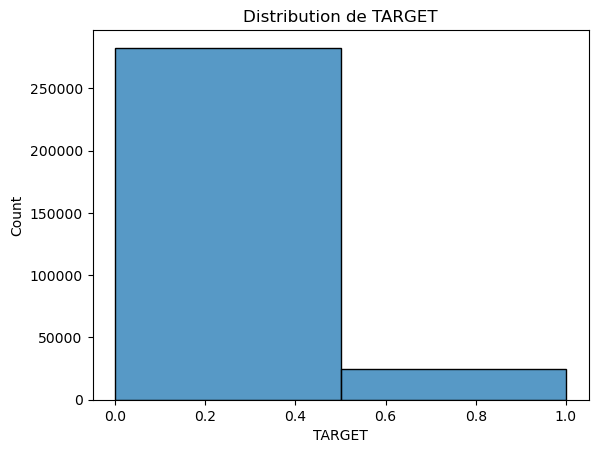

In [11]:
print("\n=== Distribution de TARGET ===")
print(df_train['TARGET'].value_counts())
sns.histplot(df_train['TARGET'], bins=2)
plt.title("Distribution de TARGET")
plt.show()

Nous constatons un fort d√©s√©quilibre entre les 2 valeurs de Target. La valeur 0(pr√™t a √©t√© rembours√©) est sur-repr√©sent√©e par rapport √† la valeur 1 (pr√™t en d√©faut)
Je proposerai une m√©thode de re√©quilibrage des donn√©es un peu plus tard

### Recherche d'anomalies dans les Train et Test

Lors de l'analyse exploratoire des tables, j'ai not√© des valeurs n√©gatives pour 'DAYS_BIRTH' et 'DAYS-EMPLOYED' qui m'emp√™che de lire correctement cette donn√©e

<Axes: ylabel='Frequency'>

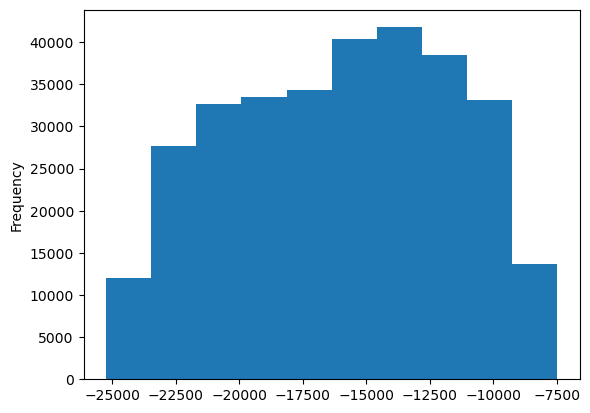

In [12]:
#Analyse de la variable DAYS_BIRTH
df_train['DAYS_BIRTH'].plot.hist()

Les valeurs de la colonne DAYS_BIRTH sont n√©gatives parce qu'elles sont enregistr√©es par rapport √† la date de la demande de pr√™t. Pour pouvoir observer ces donn√©es en ann√©es, nous allons multiplier par -1 et diviser par le nombre de jours dans une ann√©e

In [13]:
(df_train['DAYS_BIRTH'] / -365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

Ces donn√©es semblent coh√©rentes

In [14]:
#Analyse de la variable DAYS_EMPLOYED
df_train['DAYS_EMPLOYED'].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

Le max corespond √† environ 1000 ans, ce qui n'est pas r√©aliste pour une anciennet√© dans un emploi.  
Afin de savoir comment traiter cette anomalie, nous allons regarder les valeurs de notre cible pour ces donn√©es

In [15]:
anom = df_train[df_train['DAYS_EMPLOYED'] == 365243]
non_anom = df_train[df_train['DAYS_EMPLOYED'] != 365243]
print('Les non-anomalies font d√©faut sur  %0.2f%% des pr√™ts ' % (100 * non_anom['TARGET'].mean()))
print('Les anomalies font d√©faut sur %0.2f%% des pr√™ts' % (100 * anom['TARGET'].mean()))
print('Il y a %d ligne avec des DAYS_EMPLOYED anormaux' % len(anom))

Les non-anomalies font d√©faut sur  8.66% des pr√™ts 
Les anomalies font d√©faut sur 5.40% des pr√™ts
Il y a 55374 ligne avec des DAYS_EMPLOYED anormaux


Les anomalies ont un taux de d√©faut plus faible. Elles partagent peut √™tre des caract√©ristique communes.  
Je vais les remplacer par Nan et creer une nouvelle colonne bool√©enne indiquant si elle correspondait √† une anomalie ou non afin d'informer le mod√®le d'apprentissage

### Traitement des valeurs manquantes

Traitement des valeurs manquantes et anomalies pour 'DAYS_EMPLOYED' dans df_train et df_test

In [16]:
## Identification des anomalies dans DAYS_EMPLOYED
df_train['DAYS_EMPLOYED_ANOM'] = df_train["DAYS_EMPLOYED"] == 365243
df_test['DAYS_EMPLOYED_ANOM'] = df_test["DAYS_EMPLOYED"] == 365243

## Remplacement de la valeur aberrante par NaN
df_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace=True)
df_test['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace=True)

Pour les autres colonnes :

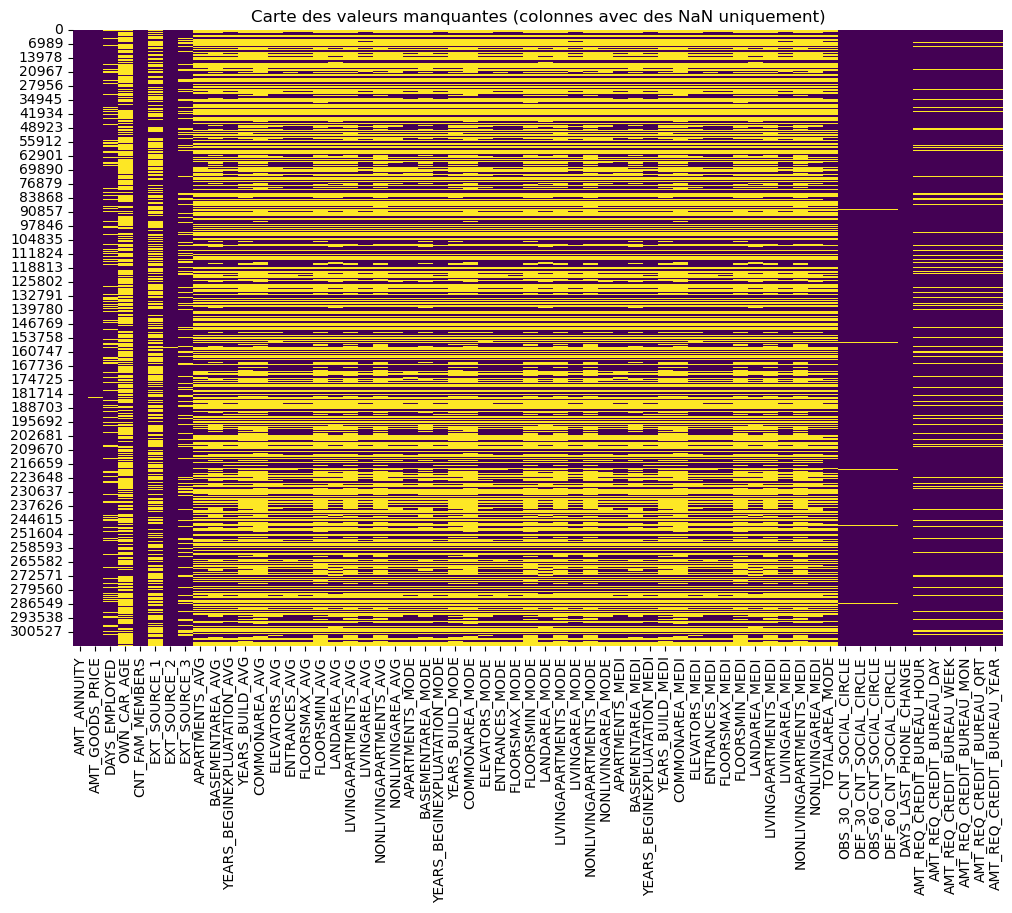

In [17]:
# Ne garder que les colonnes ayant des valeurs manquantes
cols_with_na = df_train.columns[df_train.isnull().any()]

# Heatmap des valeurs manquantes uniquement pour ces colonnes
plt.figure(figsize=(12, 8))
sns.heatmap(df_train[cols_with_na].isnull(), cbar=False, cmap="viridis")
plt.title("Carte des valeurs manquantes (colonnes avec des NaN uniquement)")
plt.show()

In [18]:
# Liste des colonnes pour l'imputation (toutes les colonnes sauf TARGET pour df_train)
features = [col for col in df_train.columns if col not in ['TARGET']]

# Imputation des valeurs manquantes
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')

# Ajustement de l'imputer sur df_train
imputer.fit(df_train[features])

# Application de l'imputer sur df_train et df_test
df_train[features] = imputer.transform(df_train[features])
df_test[features] = imputer.transform(df_test[features])

### Correlation

In [19]:
# Recherche de correlations avec la variable cible TARGET
correlations = df_train.corr()['TARGET'].sort_values()

# Affichage
print('Plus grandes correlations positives:\n', correlations.tail(15))
print('\nPlus petites correlations positives:\n', correlations.head(15))

Plus grandes correlations positives:
 OCCUPATION_TYPE_Laborers                             0.043019
FLAG_DOCUMENT_3                                      0.044346
REG_CITY_NOT_LIVE_CITY                               0.044395
FLAG_EMP_PHONE                                       0.045982
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049824
REG_CITY_NOT_WORK_CITY                               0.050994
DAYS_ID_PUBLISH                                      0.051457
CODE_GENDER_M                                        0.054713
DAYS_LAST_PHONE_CHANGE                               0.055218
NAME_INCOME_TYPE_Working                             0.057481
REGION_RATING_CLIENT                                 0.058899
REGION_RATING_CLIENT_W_CITY                          0.060893
DAYS_EMPLOYED                                        0.063368
DAYS_BIRTH                                           0.078239
TARGET                                               1.000000
Name: TARGET, dtype: float64

Pl

<Axes: xlabel='TARGET', ylabel='DAYS_BIRTH'>

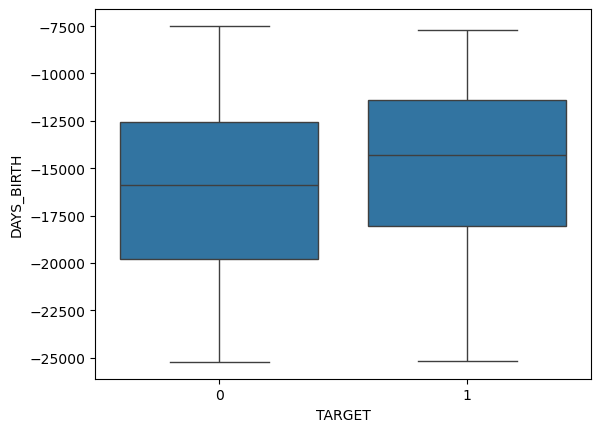

In [20]:
sns.boxplot(x='TARGET', y='DAYS_BIRTH', data=df_train)

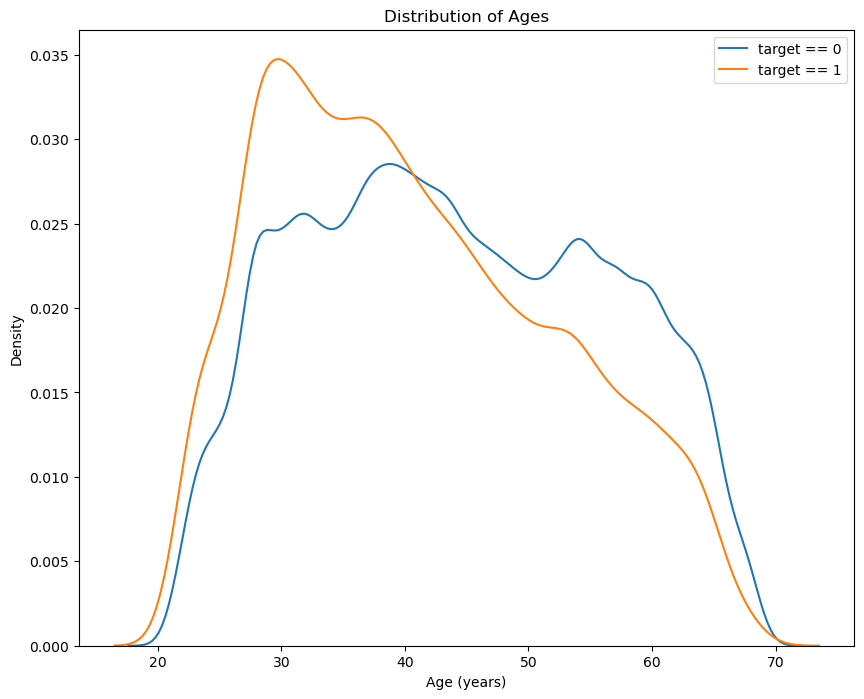

In [21]:
plt.figure(figsize = (10, 8))

# KDE des pr√™ts rembours√© √† temps
sns.kdeplot(df_train.loc[df_train['TARGET'] == 0, 'DAYS_BIRTH'] / -365, label = 'target == 0')

# KDE des pr√™ts non rembours√© √† temps
sns.kdeplot(df_train.loc[df_train['TARGET'] == 1, 'DAYS_BIRTH'] / -365, label = 'target == 1')

# Afichage du graphique
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages'); plt.legend()

Nous constatons que les clients plus √¢g√©s ont un risque de d√©faut plus faible.

Les trois variables ayant les corr√©lations n√©gatives les plus fortes avec la cible sont EXT_SOURCE_1, EXT_SOURCE_2, et EXT_SOURCE_3. Selon la documentation, ces variables repr√©sentent un "score normalis√© provenant d'une source de donn√©es externe"

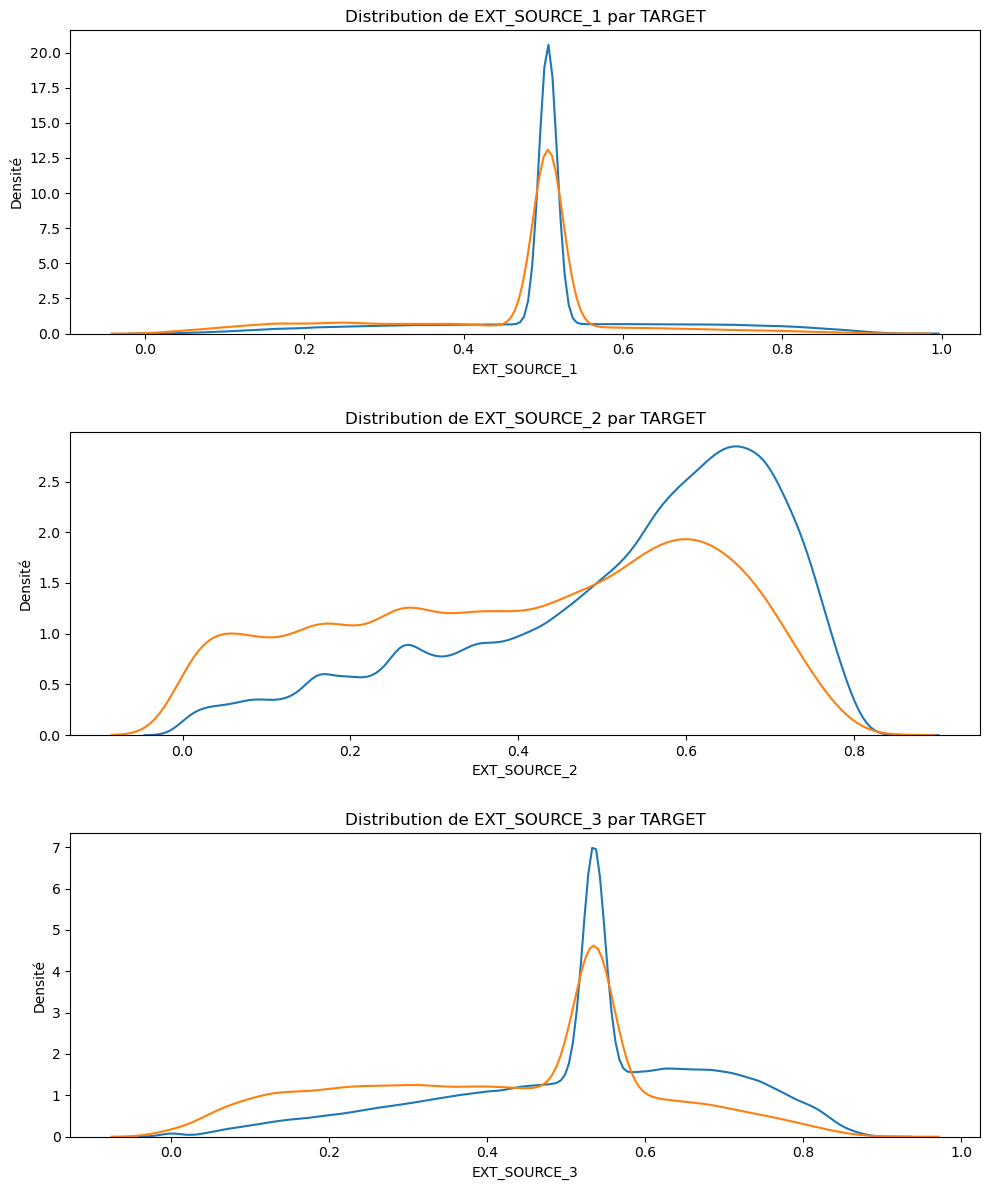

In [22]:
plt.figure(figsize = (10, 12))

# Iteration sur les variables concern√©es
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):

    # creation d'un subplot pour chaque variable
    plt.subplot(3, 1, i + 1)
    # Courbe de densit√© pour les clients ayant rembours√© leur cr√©dit (TARGET = 0)
    sns.kdeplot(df_train.loc[df_train['TARGET'] == 0, source], label = 'target == 0')
    # Courbe de densit√© pour les clients en d√©faut de paiement (TARGET = 1)
    sns.kdeplot(df_train.loc[df_train['TARGET'] == 1, source], label = 'target == 1')

    # Titre et axes du graphique
    plt.title('Distribution de %s par TARGET' % source)
    plt.xlabel('%s' % source); plt.ylabel('Densit√©');

plt.tight_layout(h_pad = 2.5)

Les graphiques de Distribution de EXT_SOURCE_2 et EXT_SOURCE_3  montre une diff√©rence notable entre les deux distributions (bleue et orange), indiquant que EXT_SOURCE_2 et EXT_SOURCE_3  ont une certaine capacit√© √† distinguer les clients qui remboursent leurs pr√™ts de ceux qui ne les remboursent pas.

### Cr√©ation de nouvelles features

**Features m√©tier**

Ces features sont inspir√©es du script https://www.kaggle.com/code/jsaguiar/lightgbm-with-simple-features?scriptVersionId=6025993

*   CREDIT_INCOME_PERCENT : le pourcentage du montant du cr√©dit par rapport aux revenus du client.
*   ANNUITY_INCOME_PERCENT : le pourcentage de l'annuit√© du pr√™t par rapport aux revenus du client.
*   CREDIT_TERM : la dur√©e de remboursement en mois (puisque l'annuit√© repr√©sente le montant d√ª chaque mois).
*   DAYS_EMPLOYED_PERCENT : le pourcentage des jours travaill√©s par rapport √† l'√¢ge du client.

In [23]:
df_train['CREDIT_INCOME_PERCENT'] = df_train['AMT_CREDIT'] / df_train['AMT_INCOME_TOTAL']
df_train['ANNUITY_INCOME_PERCENT'] = df_train['AMT_ANNUITY'] / df_train['AMT_INCOME_TOTAL']
df_train['CREDIT_TERM'] = df_train['AMT_ANNUITY'] / df_train['AMT_CREDIT']
df_train['DAYS_EMPLOYED_PERCENT'] = df_train['DAYS_EMPLOYED'] / df_train['DAYS_BIRTH']

In [24]:
df_test['CREDIT_INCOME_PERCENT'] = df_test['AMT_CREDIT'] / df_test['AMT_INCOME_TOTAL']
df_test['ANNUITY_INCOME_PERCENT'] = df_test['AMT_ANNUITY'] / df_test['AMT_INCOME_TOTAL']
df_test['CREDIT_TERM'] = df_test['AMT_ANNUITY'] / df_test['AMT_CREDIT']
df_test['DAYS_EMPLOYED_PERCENT'] = df_test['DAYS_EMPLOYED'] / df_test['DAYS_BIRTH']

**Features polynomiales**

In [25]:
# Cr√©ation des features polynomiales
poly_features = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']
poly_train, poly_test = create_polynomial_features(df_train, df_test, poly_features)

In [26]:
# Fusion des features polynomiales avec les datasets principaux
df_train = pd.merge(df_train, poly_train, on='SK_ID_CURR', how='left')
df_test = pd.merge(df_test, poly_test, on='SK_ID_CURR', how='left')

### 1ere selection de features d'interet (80)

In [27]:
# S√©paration des features et la cible
X = df_train.drop(columns=['TARGET', 'SK_ID_CURR'])
y = df_train['TARGET']

# Calcule de l'information mutuelle avec Scikit-learn
mutual_info = mutual_info_classif(X, y, random_state=42, discrete_features=False)

# Associaion des r√©sultats aux colonnes
feature_scores = pd.Series(mutual_info, index=X.columns).sort_values(ascending=False)

# 80 meilleures features
top_features = feature_scores.head(80).index.tolist()
df_train = df_train[['SK_ID_CURR', 'TARGET'] + top_features]

In [28]:
top_features

['FLAG_MOBIL',
 '1',
 'FLAG_CONT_MOBILE',
 'NAME_EDUCATION_TYPE_Secondary / secondary special',
 'CODE_GENDER_F',
 'FLAG_EMP_PHONE',
 'FLAG_DOCUMENT_3',
 'FLAG_OWN_REALTY',
 'NAME_TYPE_SUITE_Unaccompanied',
 'NAME_FAMILY_STATUS_Married',
 'NAME_HOUSING_TYPE_House / apartment',
 'FLOORSMIN_MODE',
 'FLOORSMIN_MEDI',
 'EMERGENCYSTATE_MODE_No',
 'FLOORSMIN_AVG',
 'NAME_INCOME_TYPE_Working',
 'HOUSETYPE_MODE_block of flats',
 'OWN_CAR_AGE',
 'REGION_RATING_CLIENT_W_CITY',
 'YEARS_BUILD_MEDI',
 'REGION_RATING_CLIENT',
 'LIVINGAPARTMENTS_MODE',
 'YEARS_BUILD_AVG',
 'LIVINGAPARTMENTS_AVG',
 'LIVINGAPARTMENTS_MEDI',
 'YEARS_BUILD_MODE',
 'FLOORSMAX_MODE',
 'FLOORSMAX_MEDI',
 'FLOORSMAX_AVG',
 'CNT_FAM_MEMBERS',
 'FLAG_OWN_CAR',
 'EXT_SOURCE_1_y',
 'CODE_GENDER_M',
 'EXT_SOURCE_2 EXT_SOURCE_3',
 'EXT_SOURCE_1_x',
 'BASEMENTAREA_MODE',
 'BASEMENTAREA_MEDI',
 'BASEMENTAREA_AVG',
 'EXT_SOURCE_1^2',
 'APARTMENTS_MODE',
 'CREDIT_TERM',
 'EXT_SOURCE_1 EXT_SOURCE_3',
 'ENTRANCES_MODE',
 'APARTMENTS_AVG

In [29]:
# Alignement de dt_train et df_test
## Garder uniquement les colonnes de df_train (hors TARGET) dans df_test
df_test = df_test[['SK_ID_CURR'] + top_features] 

# V√©rification
print("Taille de df_train : ", df_train.shape)
print("Taille de df_test : ", df_test.shape)

Taille de df_train :  (307511, 82)
Taille de df_test :  (48744, 81)


In [30]:
# Enregistrement des fichiers df_train et df_test en format Parquet
df_train.to_parquet(os.path.join(dataset_dir, "df_train"), index=False)
df_test.to_parquet(os.path.join(dataset_dir, "df_test"), index=False)

print(f"Fichiers enregistr√©s avec succ√®s dans le dossier : {dataset_dir}")

Fichiers enregistr√©s avec succ√®s dans le dossier : C:\Users\guigo\Documents\FORMATION\Alternance\Projet 7\Donn√©es P7


## b.Tables bureau et bureau_balance

In [31]:
def bureau_and_balance(num_rows=None, nan_as_category=True):
    # D√©finition du dossier o√π se trouve le fichier CSV
    dossier = r"C:\Users\guigo\Documents\FORMATION\Alternance\Projet 7\Donn√©es P7"

    # Chargement du fichier CSV contenant les donn√©es
    bureau = pd.read_csv(os.path.join(dossier, "bureau.csv"), nrows=num_rows)

    # R√©duction de l'utilisation de la m√©moire pour optimiser le traitement
    bureau = reduce_mem_usage(bureau)

    bb = pd.read_csv(os.path.join(dossier, "bureau_balance.csv"), nrows=num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bb = reduce_mem_usage(bb)

    # Encodage one-hot des variables cat√©gorielles si n√©cessaire
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)

    print("\n Colonnes apr√®s One-Hot Encoding :", bb.columns.tolist())

    # D√©finition des agr√©gations √† appliquer sur les colonnes de bureau_balance
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}

    # Agr√©gation des colonnes dont le nom commence par "STATUS_"
    for col in bb.columns:
        if col.startswith("STATUS_"):
            bb_aggregations[col] = ['mean']

    print("\n Colonnes utilis√©es pour l'agr√©gation :", list(bb_aggregations.keys()))

    # Regroupement des donn√©es par 'SK_ID_BUREAU' et application des agr√©gations d√©finies
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations).reset_index()

    print("\n Colonnes apr√®s agr√©gation :", bb_agg.columns.tolist())

     # Renommage des colonnes pour indiquer qu'elles proviennent de bureau_balance
    bb_agg.columns = ["CC_" + "_".join(map(str, col)).upper() if isinstance(col, tuple) else "CC_" + col for col in bb_agg.columns]

    # V√©rification et correction des noms de colonnes pour 'SK_ID_BUREAU'
    if "CC_SK_ID_BUREAU" in bb_agg.columns:
        bb_agg.rename(columns={"CC_SK_ID_BUREAU": "SK_ID_BUREAU"}, inplace=True)
    if "CC_SK_ID_BUREAU_" in bb_agg.columns:
        bb_agg.rename(columns={"CC_SK_ID_BUREAU_": "SK_ID_BUREAU"}, inplace=True)

    print("\n Colonnes apr√®s renommage de SK_ID_BUREAU :", bb_agg.columns.tolist())

    # Fusion des donn√©es du fichier bureau avec celles de bureau_balance agr√©g√©
    bureau = bureau.merge(bb_agg, on='SK_ID_BUREAU', how='left')

    # Suppression de la colonne 'SK_ID_BUREAU' qui n'est plus n√©cessaire apr√®s fusion
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace=True)

    # Lib√©ration de la m√©moire en supprimant les objets inutilis√©s
    del bb, bb_agg
    gc.collect()

    # D√©finition des agr√©gations √† appliquer sur les colonnes num√©riques de bureau
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],  # Statistiques sur les jours de cr√©dit
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],  # Dates de fin de cr√©dit
        'DAYS_CREDIT_UPDATE': ['mean'],  # Derni√®re mise √† jour du cr√©dit
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],  # Nombre de jours de retard
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],  # Montant maximum du cr√©dit en retard
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],  # Somme des montants de cr√©dit
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],  # Somme des dettes de cr√©dit
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],  # Montant en retard de paiement
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],  # Limite de cr√©dit
        'AMT_ANNUITY': ['max', 'mean'],  # Annuit√© des cr√©dits
        'CNT_CREDIT_PROLONG': ['sum'],  # Nombre de fois o√π le cr√©dit a √©t√© prolong√©
        'CC_MONTHS_BALANCE_MIN': ['min'],  # Mois minimum du cr√©dit
        'CC_MONTHS_BALANCE_MAX': ['max'],  # Mois maximum du cr√©dit
        'CC_MONTHS_BALANCE_SIZE': ['mean', 'sum']  # Taille de l'historique du cr√©dit
    }

    # D√©finition des agr√©gations pour les variables cat√©gorielles
    cat_aggregations = {}

    # Ajout des variables cat√©gorielles du fichier bureau
    for cat in bureau_cat:
        cat_aggregations[cat] = ['mean']
    for cat in bb_cat:
        if f"CC_{cat}_MEAN" in bureau.columns:
            cat_aggregations[f"CC_{cat}_MEAN"] = ['mean']

    # Agr√©gation des donn√©es finales par client 'SK_ID_CURR'
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations}).reset_index()

    print("\n V√©rification de SK_ID_CURR apr√®s agr√©gation :", "SK_ID_CURR" in bureau_agg.columns)

    print("\n Colonnes apr√®s agr√©gation bureau :", bureau_agg.columns.tolist())

    # Renommage des colonnes pour indiquer qu'elles proviennent du fichier bureau
    bureau_agg.columns = [
        "BURO_" + "_".join(map(str, col)).upper() if isinstance(col, tuple) else "BURO_" + str(col)
        for col in bureau_agg.columns
    ]

    # V√©rification et correction si 'SK_ID_CURR' est absent du dataset final
    if "SK_ID_CURR" not in bureau_agg.columns:
        bureau_agg.rename(columns={col: "SK_ID_CURR" for col in bureau_agg.columns if "SK_ID_CURR" in col}, inplace=True)

    # Suppression des '_'' en trop dans les noms de colonnes
    bureau_agg.columns = [col[:-1] if col.endswith("_") else col for col in bureau_agg.columns]

    print("\n V√©rification finale de SK_ID_CURR :", "SK_ID_CURR" in bureau_agg.columns)
    print("\n Colonnes apr√®s renommage final :", bureau_agg.columns.tolist())

    # Retourne les donn√©es agr√©g√©es et transform√©es
    return bureau_agg

## c. Table previous application

In [32]:
def previous_applications(num_rows=None, nan_as_category=True):
    dossier = r"C:\Users\guigo\Documents\FORMATION\Alternance\Projet 7\Donn√©es P7"
    prev = pd.read_csv(os.path.join(dossier, "previous_application.csv"), nrows=num_rows)

    # R√©duction de la m√©moire
    prev = reduce_mem_usage(prev)

    # Encodage one-hot des variables cat√©gorielles
    prev, cat_cols = one_hot_encoder(prev, nan_as_category=True)

    # V√©rification des colonnes apr√®s One-Hot Encoding
    print("\n Colonnes apr√®s One-Hot Encoding :", prev.columns.tolist())

    # Remplacement des valeurs 365243 par NaN
    date_cols = ['DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION',
                 'DAYS_LAST_DUE', 'DAYS_TERMINATION']
    prev[date_cols] = prev[date_cols].replace(365243, np.nan)

    # Ajout de la variable : rapport entre montant demand√© et cr√©dit accord√©
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']

    # D√©finition des agr√©gations num√©riques
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }

    # D√©finition des agr√©gations cat√©gorielles
    cat_aggregations = {cat: ['mean'] for cat in cat_cols if cat in prev.columns}

    # V√©rifier que les colonnes existent avant d'agr√©ger
    valid_aggregations = {
        col: funcs for col, funcs in {**num_aggregations, **cat_aggregations}.items() if col in prev.columns
    }

    # S√©parer les colonnes num√©riques et cat√©gorielles
    num_cols = list(num_aggregations.keys())
    cat_cols = list(cat_aggregations.keys())

    # Agr√©gation seulement sur les colonnes existantes
    prev_agg = prev.groupby('SK_ID_CURR')[num_cols].agg(num_aggregations)

    # Correction du MultiIndex apr√®s aggregation
    prev_agg.columns = [
        "PREV_" + "_".join(map(str, col)).upper() if isinstance(col, tuple) else "PREV_" + col
        for col in prev_agg.columns
    ]
    prev_agg.reset_index(inplace=True)

    # V√©rification apr√®s agr√©gation
    print("\n Colonnes apr√®s agr√©gation principale :", prev_agg.columns.tolist())

    # Agr√©gation sp√©cifique : Applications approuv√©es
    if 'NAME_CONTRACT_STATUS_Approved' in prev.columns:
        approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1].copy()
        if not approved.empty:
            approved_agg = approved.groupby('SK_ID_CURR')[num_cols].agg(num_aggregations)
            approved_agg.columns = [
                "APPROVED_" + "_".join(map(str, col)).upper() if isinstance(col, tuple) else "APPROVED_" + col
                for col in approved_agg.columns
            ]
            approved_agg.reset_index(inplace=True)
            prev_agg = prev_agg.merge(approved_agg, on='SK_ID_CURR', how='left')

    # Agr√©gation sp√©cifique : Applications refus√©es
    if 'NAME_CONTRACT_STATUS_Refused' in prev.columns:
        refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1].copy()
        if not refused.empty:
            refused_agg = refused.groupby('SK_ID_CURR')[num_cols].agg(num_aggregations)
            refused_agg.columns = [
                "REFUSED_" + "_".join(map(str, col)).upper() if isinstance(col, tuple) else "REFUSED_" + col
                for col in refused_agg.columns
            ]
            refused_agg.reset_index(inplace=True)
            prev_agg = prev_agg.merge(refused_agg, on='SK_ID_CURR', how='left')

    # V√©rification finale de `SK_ID_CURR`
    print("\n V√©rification finale de SK_ID_CURR :", "SK_ID_CURR" in prev_agg.columns)

    # Affichage des colonnes finales apr√®s agr√©gation et renommage
    print("\n Colonnes apr√®s renommage final :", prev_agg.columns.tolist())

    # Nettoyage m√©moire
    del refused, approved, prev
    gc.collect()

    return prev_agg

## d.Table POSH_CASH_balance

In [33]:
# Pr√©traitement du fichier POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = True):
    dossier = r"C:\Users\guigo\Documents\FORMATION\Alternance\Projet 7\Donn√©es P7"
    pos = pd.read_csv(os.path.join(dossier, "POS_CASH_balance.csv"), nrows=num_rows)
    pos = reduce_mem_usage(pos)
    print("\nColonnes au chargement :", pos.columns.tolist())  # V√©rifier les colonnes au d√©but
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)

    # D√©finition des agr√©gations √† appliquer sur les donn√©es
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }

    # Ajout des variables cat√©gorielles encod√©es aux agr√©gations (calcul de la moyenne)
    for cat in cat_cols:
        aggregations[cat] = ['mean']

    # Agr√©gation des donn√©es par identifiant client `SK_ID_CURR`
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)

    # Renommage des colonnes pour pr√©ciser qu'elles proviennent des donn√©es POS CASH
    pos_agg.columns = ["POS_" + "_".join(map(str, e)).upper() if isinstance(e, tuple) else "POS_" + str(e) for e in pos_agg.columns]

    # Ajout d'une nouvelle colonne qui indique le nombre total de comptes POS CASH par client
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()

    # Suppression des donn√©es originales pour lib√©rer de la m√©moire
    del pos
    gc.collect()

    # Retourne le DataFrame agr√©g√©
    return pos_agg

## e.Table Installments_payments

In [34]:
# Pr√©traitement du fichier installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):
    dossier = r"C:\Users\guigo\Documents\FORMATION\Alternance\Projet 7\Donn√©es P7"
    ins = pd.read_csv(os.path.join(dossier, "installments_payments.csv"), nrows=num_rows)
    
    ins = reduce_mem_usage(ins)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)

    # Calcul du pourcentage du montant pay√© par rapport au montant de l'√©ch√©ance
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']

    # Calcul du retard de paiement (jours de d√©passement)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)

    # D√©finition des agr√©gations pour regrouper les donn√©es par client (SK_ID_CURR)
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],  # Nombre unique de versions d'√©ch√©ance
        'DPD': ['max', 'mean', 'sum'],  # Retard de paiement max, moyen et total
        'DBD': ['max', 'mean', 'sum'],  # Nombre de jours avant √©ch√©ance max, moyen et total
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],  # Statistiques sur le pourcentage pay√©
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],  # Statistiques sur la diff√©rence de paiement
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],  # Montant de l'√©ch√©ance max, moyen et total
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],  # Montant pay√© min, max, moyen et total
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']  # Jours d'entr√©e de paiement max, moyen et total
    }

     # Ajout des variables cat√©gorielles encod√©es aux agr√©gations
    for cat in cat_cols:
        aggregations[cat] = ['mean']

    # Agr√©gation des donn√©es par client (SK_ID_CURR)
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)

    # Renommage des colonnes pour indiquer qu'il s'agit de donn√©es d'√©ch√©ances
    ins_agg.columns = ["INSTAL_" + "_".join(map(str, e)).upper() if isinstance(e, tuple) else "INSTAL_" + str(e) for e in ins_agg.columns]

    # Comptage du nombre total d'√©ch√©ances pour chaque client
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()

    # Lib√©ration de la m√©moire en supprimant la variable ins
    del ins
    gc.collect()

    # Retourne le DataFrame agr√©g√©
    return ins_agg

## f.Table credit_card_balance

In [35]:
# Pr√©traitement du fichier credit_card_balance.csv
def credit_card_balance(num_rows=None, nan_as_category=True):
    dossier = r"C:\Users\guigo\Documents\FORMATION\Alternance\Projet 7\Donn√©es P7"
    cc = pd.read_csv(os.path.join(dossier, "credit_card_balance.csv"), nrows=num_rows)
    cc = reduce_mem_usage(cc)                
    
    cc, cat_cols = one_hot_encoder(cc, nan_as_category=nan_as_category)

    # D√©finition des agr√©gations pour regrouper les donn√©es
    num_aggregations = {
        'MONTHS_BALANCE': ['min', 'max', 'mean', 'sum', 'var'],  # Historique des mois d'utilisation de la carte
        'AMT_BALANCE': ['min', 'max', 'mean', 'sum', 'var'],  # Solde du compte de carte de cr√©dit
        'AMT_CREDIT_LIMIT_ACTUAL': ['min', 'max', 'mean', 'sum', 'var'],  # Limite de cr√©dit actuelle
        'AMT_DRAWINGS_ATM_CURRENT': ['min', 'max', 'mean', 'sum', 'var'],  # Retraits effectu√©s aux distributeurs
        'AMT_DRAWINGS_CURRENT': ['min', 'max', 'mean', 'sum', 'var'],  # Montant total des retraits
        'AMT_DRAWINGS_OTHER_CURRENT': ['min', 'max', 'mean', 'sum', 'var'],  # Retraits effectu√©s hors distributeurs et points de vente
        'AMT_DRAWINGS_POS_CURRENT': ['min', 'max', 'mean', 'sum', 'var'],  # Montant des achats effectu√©s en point de vente
        'AMT_INST_MIN_REGULARITY': ['min', 'max', 'mean', 'sum', 'var'],  # Montant minimum des paiements r√©guliers
        'AMT_PAYMENT_CURRENT': ['min', 'max', 'mean', 'sum', 'var'],  # Montant du dernier paiement
        'AMT_PAYMENT_TOTAL_CURRENT': ['min', 'max', 'mean', 'sum', 'var'],  # Montant total des paiements
        'AMT_RECEIVABLE_PRINCIPAL': ['min', 'max', 'mean', 'sum', 'var'],  # Capital restant d√ª
        'AMT_RECIVABLE': ['min', 'max', 'mean', 'sum', 'var'],  # Montant total recevable (possible duplication avec `AMT_TOTAL_RECEIVABLE`)
        'AMT_TOTAL_RECEIVABLE': ['min', 'max', 'mean', 'sum', 'var'],  # Montant total restant √† recevoir
        'CNT_DRAWINGS_ATM_CURRENT': ['min', 'max', 'mean', 'sum', 'var'],  # Nombre de retraits aux distributeurs
        'CNT_DRAWINGS_CURRENT': ['min', 'max', 'mean', 'sum', 'var'],  # Nombre total de retraits effectu√©s
        'CNT_DRAWINGS_OTHER_CURRENT': ['min', 'max', 'mean', 'sum', 'var'],  # Nombre de retraits hors ATM et point de vente
        'CNT_DRAWINGS_POS_CURRENT': ['min', 'max', 'mean', 'sum', 'var'],  # Nombre d'achats effectu√©s en point de vente
        'CNT_INSTALMENT_MATURE_CUM': ['min', 'max', 'mean', 'sum', 'var'],  # Nombre cumul√© d'√©ch√©ances √©chues
        'SK_DPD': ['min', 'max', 'mean', 'sum', 'var'],  # Nombre de jours de retard
        'SK_DPD_DEF': ['min', 'max', 'mean', 'sum', 'var']  # Nombre de jours de d√©faut de paiement
    }

    # D√©finition des agr√©gations pour les variables cat√©gorielles encod√©es
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']  # Moyenne pour les variables cat√©gorielles encod√©es

    # Agr√©gation des donn√©es par client (`SK_ID_CURR`)
    cc_agg = cc.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})

    # Renommage des colonnes pour pr√©ciser qu'elles proviennent des donn√©es de carte de cr√©dit
    cc_agg.columns = ["CC_" + "_".join(map(str, e)).upper() if isinstance(e, tuple) else "CC_" + str(e)
                      for e in cc_agg.columns]

    # R√©initialisation de l'index pour conserver `SK_ID_CURR` comme colonne classique
    cc_agg.reset_index(inplace=True)

    # Retourne le DataFrame agr√©g√©
    return cc_agg

# 4.Cr√©ation du dataframe final avant mod√©lisation

In [36]:
# Chargement des fichiers df_train et df_test depuis le format Parquet
df_train = pd.read_parquet(os.path.join(dataset_dir, "df_train"))
df_test = pd.read_parquet(os.path.join(dataset_dir, "df_test"))

print("Fichiers charg√©s avec succ√®s !")

Fichiers charg√©s avec succ√®s !


In [37]:
def prepare_merged_data(debug=False):
    # D√©finition du nombre de lignes √† traiter en mode debug (limite √† 10 000 lignes si debug=True)
    num_rows = 10000 if debug else None

    # V√©rification de la disponibilit√© des DataFrames df_train et df_test
    print("\n V√©rification de df_train et df_test :", hasattr(df_train, "name"), hasattr(df_test, "name"))

    # Fusion des donn√©es d'entra√Ænement (df_train) et de test (df_test)
    df = pd.concat([df_train, df_test], axis=0)

    # Traitement des donn√©es de bureau et bureau_balance
    with timer("Process bureau and bureau_balance"):
        bureau = bureau_and_balance(num_rows) # Chargement et agr√©gation des donn√©es bureau
        df = df.merge(bureau, on='SK_ID_CURR', how='left') # Fusion avec les donn√©es principales
        del bureau # Suppression de l'objet pour lib√©rer la m√©moire
        gc.collect() # Nettoyage de la m√©moire

    # Traitement des demandes de cr√©dit pr√©c√©dentes
    with timer("Process previous applications"):
        prev = previous_applications(num_rows)
        df = df.merge(prev, on='SK_ID_CURR', how='left')
        del prev
        gc.collect()

    # Traitement des donn√©es POS-CASH balance (cr√©dits renouvelables)
    with timer("Process POS-CASH balance"):
        pos = pos_cash(num_rows)
        df = df.merge(pos, on='SK_ID_CURR', how='left')
        del pos
        gc.collect()

    # Traitement des paiements d'acompte
    with timer("Process installments payments"):
        ins = installments_payments(num_rows)
        df = df.merge(ins, on='SK_ID_CURR', how='left')
        del ins
        gc.collect()

    # Traitement des balances de carte de cr√©dit
    with timer("Process credit card balance"):
        cc = credit_card_balance(num_rows)
        df = df.merge(cc, on='SK_ID_CURR', how='left')
        del cc
        gc.collect()

    # R√©duction de la m√©moire et sauvegarde du DataFrame final
    df = reduce_mem_usage(df)
    df.to_parquet("merged_df.parquet", index=False)
    file_path = "merged_df.parquet"
    display(FileLink(file_path))
    print("DataFrame fusionn√© sauvegard√© en Parquet.")

    # Retourne le DataFrame fusionn√©
    return df

In [38]:
def prepare_train_test_split(df):
    """
    S√©pare le DataFrame en ensemble d'entra√Ænement et de test.

    Arguments :
    df : DataFrame contenant les donn√©es fusionn√©es.

    Retourne :
    - X_train : Features pour l'entra√Ænement.
    - X_test : Features pour le test.
    - y_train : Cible pour l'entra√Ænement.
    - y_test : Cible pour le test.
    """

    # S√©lection des donn√©es d'entra√Ænement en gardant uniquement les lignes o√π la variable TARGET est connue (non nulle)
    df_train_final = df[df['TARGET'].notnull()]

    # S√©paration des features (X) et de la cible (y)
    X = df_train_final.drop(columns=['TARGET', 'SK_ID_CURR'])  # Enlever TARGET et ID client
    y = df_train_final['TARGET']  # Variable cible

    # D√©coupage des donn√©es en ensemble d'entra√Ænement et de test (avec stratification)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    # Affichage des tailles des ensembles cr√©√©s
    print("Taille de l'ensemble d'entra√Ænement :", X_train.shape)
    print("Taille de l'ensemble de test :", X_test.shape)

    return X_train, X_test, y_train, y_test

In [39]:
if __name__ == "__main__":
    """
    Ce bloc de code est ex√©cut√© uniquement si le script est lanc√© directement.
    Il permet de pr√©parer les donn√©es, entra√Æner un mod√®le RendomForest et extraire les caract√©ristiques les plus importantes.
    """

    # Pr√©paration des donn√©es
    print("=== √âtape 1 : Pr√©paration des donn√©es ===")
    df = prepare_merged_data(debug=False)
    df = df.rename(columns=lambda c: re.sub('_+', '_', re.sub('[^A-Za-z0-9_]+', '_', c)))
    
    # S√©lection rapide des caract√©ristiques
    print("\n=== √âtape 2 : S√©lection rapide des features ===")
    
    # Feature importance RandomForest
    selected_features, importance_df = select_features_with_sampling(
        df, 
        target_col='TARGET', 
        n_features=40, 
        sample_size=50000  
    )
    
    # Sauvegarde des importances
    importance_df.to_csv("feature_importance.csv", index=False)
    print("Importance des features sauvegard√©e dans 'feature_importance.csv'.")
    
    # Cr√©ation du DataFrame r√©duit
    print("\n=== √âtape 3 : Cr√©ation du DataFrame r√©duit ===")
    reduced_df = df[selected_features + ['TARGET', 'SK_ID_CURR']]
    print(f"Le DataFrame r√©duit contient {reduced_df.shape[1]} colonnes.")
    print(reduced_df.head())
    
    # Pr√©paration des ensembles train/test
    print("\n=== √âtape 4 : Pr√©paration des ensembles train/test ===")
    X_train, X_test, y_train, y_test = prepare_train_test_split(reduced_df)

=== √âtape 1 : Pr√©paration des donn√©es ===

 V√©rification de df_train et df_test : False False
Memory usage of dataframe is 222.62 MB
Memory usage after optimization is: 119.49 MB
Memory usage of dataframe is 650.88 MB
Memory usage after optimization is: 1067.44 MB

 Colonnes apr√®s One-Hot Encoding : ['SK_ID_BUREAU', 'MONTHS_BALANCE', 'STATUS_0', 'STATUS_1', 'STATUS_2', 'STATUS_3', 'STATUS_4', 'STATUS_5', 'STATUS_C', 'STATUS_X', 'STATUS_nan']

 Colonnes utilis√©es pour l'agr√©gation : ['MONTHS_BALANCE', 'STATUS_0', 'STATUS_1', 'STATUS_2', 'STATUS_3', 'STATUS_4', 'STATUS_5', 'STATUS_C', 'STATUS_X', 'STATUS_nan']

 Colonnes apr√®s agr√©gation : [('SK_ID_BUREAU', ''), ('MONTHS_BALANCE', 'min'), ('MONTHS_BALANCE', 'max'), ('MONTHS_BALANCE', 'size'), ('STATUS_0', 'mean'), ('STATUS_1', 'mean'), ('STATUS_2', 'mean'), ('STATUS_3', 'mean'), ('STATUS_4', 'mean'), ('STATUS_5', 'mean'), ('STATUS_C', 'mean'), ('STATUS_X', 'mean'), ('STATUS_nan', 'mean')]

 Colonnes apr√®s renommage de SK_ID_BUR

C:\Users\guigo\Documents\FORMATION\Alternance\Projet 7\merged_df.parquet

DataFrame fusionn√© sauvegard√© en Parquet.

=== √âtape 2 : S√©lection rapide des features ===
Utilisation d'un √©chantillon de 50000 lignes pour la s√©lection des features
Importance des features sauvegard√©e dans 'feature_importance.csv'.

=== √âtape 3 : Cr√©ation du DataFrame r√©duit ===
Le DataFrame r√©duit contient 42 colonnes.
   EXT_SOURCE_2_EXT_SOURCE_3  EXT_SOURCE_2_DAYS_BIRTH  \
0                   0.036649             -2487.756836   
1                   0.333073            -10431.950195   
2                   0.405575            -10587.901367   
3                   0.348166            -12361.644531   
4                   0.172754             -6432.819824   

   EXT_SOURCE_1_EXT_SOURCE_2  EXT_SOURCE_2_2  EXT_SOURCE_1_EXT_SOURCE_3  \
0                   0.021834        0.069142                   0.011573   
1                   0.193685        0.387190                   0.166614   
2                   0.281290        0.309038                   0.369159   
3                   0.

In [40]:
# Cr√©ation d'un dossier pour stocker les fichiers Parquet
os.makedirs("saved_data", exist_ok=True)

# Sauvegarde des fichiers en Parquet
X_train.to_parquet("saved_data/X_train.parquet", index=False)
X_test.to_parquet("saved_data/X_test.parquet", index=False)

# Conversion de y_train et y_test en DataFrame avant d'enregistrer
y_train.to_frame().to_parquet("saved_data/y_train.parquet", index=False)
y_test.to_frame().to_parquet("saved_data/y_test.parquet", index=False)

print("‚úÖ X_train, X_test, y_train et y_test ont √©t√© enregistr√©s en Parquet.")

‚úÖ X_train, X_test, y_train et y_test ont √©t√© enregistr√©s en Parquet.


In [41]:
# Cr√©ation d'un fichier client
Base_client = pd.read_parquet("merged_df.parquet")

# Nettoyage complet des noms de colonnes
Base_client.columns = [re.sub('_+', '_', re.sub('[^A-Za-z0-9_]+', '_', col)).strip('_') for col in Base_client.columns]

# On r√©duit √† 300 clients seulement
ids_clients = Base_client["SK_ID_CURR"].sample(300, random_state=42).tolist()
Base_client = Base_client[Base_client["SK_ID_CURR"].isin(ids_clients)]

# V√©rifie si les colonnes sont maintenant bien nomm√©es
print("‚úÖ Colonnes apr√®s nettoyage :", [col for col in df.columns if "EXT" in col])

# Sauvegarde le fichier en Parquet
Base_client.to_parquet("saved_data/Base_client.parquet", index=False)

‚úÖ Colonnes apr√®s nettoyage : ['EXT_SOURCE_1_y', 'EXT_SOURCE_2_EXT_SOURCE_3', 'EXT_SOURCE_1_x', 'EXT_SOURCE_1_2', 'EXT_SOURCE_1_EXT_SOURCE_3', 'EXT_SOURCE_3_x', 'EXT_SOURCE_1_EXT_SOURCE_2', 'EXT_SOURCE_3_y', 'EXT_SOURCE_3_2', 'EXT_SOURCE_2_DAYS_BIRTH', 'EXT_SOURCE_2_2', 'EXT_SOURCE_2_x', 'EXT_SOURCE_2_y', 'EXT_SOURCE_3_DAYS_BIRTH']


# 5. D√©termination d'un score m√©tier

Dans cette section, nous allons d√©finir un score m√©tier pertinent afin d'√©valuer l'impact financier des erreurs de pr√©diction du mod√®le, puis d√©terminer un seuil optimal de classification.

In [42]:
# Remplacement des valeurs nan
X_train = X_train.replace([np.inf, -np.inf], np.nan)
X_test = X_test.replace([np.inf, -np.inf], np.nan)

## 5.1 D√©finition d'une fonction de co√ªt m√©tier

Nous introduisons une fonction de co√ªt m√©tier pour refl√©ter l'impact √©conomique des erreurs du mod√®le :
- Faux N√©gatif (FN) : accorder un pr√™t √† un client risqu√© co√ªte 10 unit√©s (perte potentielle √©lev√©e).
- Faux Positif (FP) : refuser un pr√™t √† un bon client co√ªte 1 unit√© (manque √† gagner limit√©).

La fonction de co√ªt m√©tier est donc d√©finie comme :
Co√ªt total = 10 √ó FN + 1 √ó FP.

In [43]:
def business_cost(y_true, y_pred):
    # D√©compose la matrice de confusion
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    # Calcul du co√ªt m√©tier
    cost = 10 * fn + 1 * fp
    return cost

In [44]:
business_cost_scorer = make_scorer(business_cost, greater_is_better=False)  # Minimise le co√ªt

## 5.2 Recherche du seuil optimal de d√©cision

Pour convertir les probabilit√©s de pr√©diction en d√©cisions binaires, nous identifions le seuil minimisant le co√ªt m√©tier. Ce seuil permet de maximiser l'efficacit√© √©conomique du mod√®le en prenant en compte l'asym√©trie du co√ªt des erreurs.

### Fonction de recherche du seuil optimal

Cette fonction permet d‚Äôexplorer plusieurs seuils de d√©cision compris entre 0 et 1 (avec un pas de 0,01) afin de d√©terminer celui minimisant le co√ªt m√©tier total.

In [45]:
# Fonction pour d√©terminer le seuil optimal 
def find_optimal_threshold(y_true, y_proba):
    """
    Trouve le seuil optimal pour convertir des probabilit√©s en pr√©dictions binaires,
    en minimisant un co√ªt m√©tier d√©fini.

    Arguments :
    - y_true : np.array, liste des vraies valeurs de la cible (0 ou 1).
    - y_proba : np.array, liste des probabilit√©s pr√©dites par le mod√®le.

    Retourne :
    - best_threshold : float, seuil optimal qui minimise le co√ªt m√©tier.
    - min_cost : float, co√ªt minimal obtenu avec ce seuil.
    """

    # G√©n√©ration d'une liste de seuils de d√©cision entre 0 et 1 (avec un pas de 0.01)
    thresholds = np.linspace(0, 1, 101)  # 101 seuils de 0.0 √† 1.0

    # Initialisation des variables pour stocker le meilleur seuil et le co√ªt minimal
    best_threshold = 0
    min_cost = float('inf')  # Infini positif pour garantir la premi√®re mise √† jour

    # Parcours de chaque seuil pour trouver celui qui minimise le co√ªt m√©tier
    for threshold in thresholds:
        # Conversion des probabilit√©s en pr√©dictions binaires selon le seuil actuel
        y_pred = (y_proba >= threshold).astype(int)
        cost = business_cost(y_true, y_pred)

        # Mise √† jour du seuil optimal si un co√ªt plus faible est trouv√©
        if cost < min_cost:
            min_cost = cost
            best_threshold = threshold

    # Retourne le seuil optimal et le co√ªt minimum atteint
    return best_threshold, min_cost

### D√©finition des fonctions de scoring bas√©es sur le seuil optimal

Pour int√©grer cette recherche du seuil optimal directement dans l‚Äô√©valuation des mod√®les, nous cr√©ons deux m√©triques adapt√©es :
- Un scorer bas√© sur le co√ªt m√©tier optimal.
- Un scorer bas√© sur le F1-score optimal.

In [46]:
# Fonction retournant uniquement le co√ªt m√©tier minimal (utile pour GridSearchCV)
def optimal_threshold_business_cost(y_true, y_proba):
    """Trouve le seuil optimal et retourne le co√ªt m√©tier minimis√©"""
    _, min_cost = find_optimal_threshold(y_true, y_proba)
    return min_cost 

In [47]:
# Cr√©ation du scorer de co√ªt m√©tier optimal pour GridSearchCV
optimal_cost_scorer = make_scorer(optimal_threshold_business_cost, needs_proba=True, greater_is_better=False)

In [48]:
# Fonction retournant le F1-score calcul√© avec le seuil optimal trouv√©
def optimal_f1_score(y_true, y_proba):
    best_threshold, _ = find_optimal_threshold(y_true, y_proba)
    y_pred = (y_proba >= best_threshold).astype(int)
    return f1_score(y_true, y_pred)

In [49]:
# Cr√©ation du scorer F1 optimal pour GridSearchCV
optimal_f1_scorer = make_scorer(optimal_f1_score, needs_proba=True)

# 6.Comparaison et optimisation des mod√®les

Cette partie vise √† comparer plusieurs mod√®les en int√©grant :
- un pipeline avec SMOTE pour g√©rer le d√©s√©quilibre entre les classes
- une fonction de co√ªt m√©tier afin de s√©lectionner le mod√®le optimal



In [50]:
# D√©finition du dossier pour stocker les mod√®les et artefacts
artifacts_dir = "C:/Users/guigo/Documents/FORMATION/Alternance/Projet 7/mlruns/artifacts"
model_dir = os.path.join(artifacts_dir, "models")
os.makedirs(artifacts_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)

print(f"Les mod√®les seront enregistr√©s dans : {model_dir}")

Les mod√®les seront enregistr√©s dans : C:/Users/guigo/Documents/FORMATION/Alternance/Projet 7/mlruns/artifacts\models


## 6.1 Pr√©paration du pipeline de pr√©traitement

Nous pr√©parons un pipeline de pr√©traitement commun √† tous les mod√®les. Celui-ci inclut :
- L‚Äôimputation des valeurs manquantes.
- La standardisation des variables num√©riques.
- Le traitement sp√©cifique des variables binaires.

In [51]:
# D√©finition du pr√©processeur
# D√©tection des colonnes num√©riques et binaires
binary_cols = [col for col in X_train.columns if set(X_train[col].dropna().unique()).issubset({0, 1})]
numeric_cols = [col for col in X_train.columns if col not in binary_cols]

preprocessor = ColumnTransformer([
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]), numeric_cols),
    ('bin', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent'))
    ]), binary_cols)
])

## 6.2 D√©finition des pipelines avec SMOTE

Nous cr√©ons une fonction qui int√®gre la m√©thode SMOTE pour √©quilibrer les donn√©es, combin√©e au pr√©processeur, afin de constituer un pipeline pr√™t √† √™tre utilis√© avec diff√©rents mod√®les.

In [52]:
# Pipelines avec SMOTE
def create_pipeline(model):
    return ImbPipeline([
        ('preprocessing', preprocessor),
        ('smote', SMOTE(sampling_strategy=0.3, random_state=42)),
        ('classifier', model)
    ])

## 6.3 S√©lection et param√©trage initial des mod√®les √† comparer

4 mod√®les sont compar√©s :
- DummyClassifier (mod√®le na√Øf de r√©f√©rence).
- Random Forest.
- XGBoost.
- LightGBM.
Pour chacun, une grille d‚Äôhyperparam√®tres simplifi√©e est d√©finie pour une premi√®re √©valuation.

In [53]:
models = {
    "Dummy": (DummyClassifier(strategy="most_frequent"), {}),
    
    "RandomForest": (RandomForestClassifier(random_state=42, class_weight='balanced'), {  
        'classifier__n_estimators': [50],  # R√©duit √† une seule valeur
        'classifier__max_depth': [3],  # Valeur unique optimale
        'classifier__min_samples_split': [20],  # Valeur unique
        'classifier__min_samples_leaf': [10],  # Valeur unique
        'classifier__max_features': ['sqrt']  # Option la plus l√©g√®re en m√©moire
    }),
    
    "XGBoost": (XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42), {
        'classifier__n_estimators': [50],  # Valeur unique
        'classifier__max_depth': [3],  # Valeur unique
        'classifier__learning_rate': [0.3],  # Valeur unique plus rapide
        'classifier__subsample': [0.75],  # Valeur unique
    }),
    
    "LightGBM": (LGBMClassifier(random_state=42, verbosity=-1, class_weight="balanced",force_row_wise=True), {
        'classifier__n_estimators': [350],  # Valeur unique
        'classifier__learning_rate': [0.03],  # Valeur unique
        'classifier__max_depth': [7],  # Valeur unique
        'classifier__num_leaves': [65],  # Valeur unique
        'classifier__min_child_samples': [20],  # Valeur unique
        'classifier__subsample': [0.75],  # Valeur unique
        'classifier__colsample_bytree': [0.75]  # Valeur unique
    })
}

## 6.4 D√©finition des m√©triques d‚Äô√©valuation des mod√®les

Pour comparer efficacement les mod√®les, nous d√©finissons plusieurs m√©triques, notamment :
- Le co√ªt m√©tier (prioritaire).
- L‚ÄôAUC, le F1-score, la pr√©cision et le rappel (m√©triques compl√©mentaires).

In [54]:
# Dictionnaire de m√©triques d‚Äô√©valuation
scoring_metrics = {
    'business_cost': business_cost_scorer,
    'roc_auc': make_scorer(roc_auc_score, needs_proba=True),
    'f1': 'f1',
    'precision': 'precision',
    'recall': 'recall',
    'optimal_business_cost': optimal_cost_scorer
}

## 6.5 Entra√Ænement initial des mod√®les avec GridSearchCV

In [55]:
# √âchantillonnage de 100 000 lignes pour GridSearchCV
# Si X_train contient plus de 100 000 lignes
if len(X_train) > 100000:
    X_train_sampled, _, y_train_sampled, _ = train_test_split(
        X_train, y_train, 
        train_size=100000,  # Taille fixe de 10 000
        random_state=42, 
        stratify=y_train  # Maintient la distribution des classes
    )
else:
    # Utiliser tout le jeu d'entra√Ænement si moins de 100 000 lignes
    X_train_sampled = X_train
    y_train_sampled = y_train

In [56]:
# Cross-validation stratifi√©e
cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

results = []
grids = {}  

for model_name, (model, params) in models.items():
    with mlflow.start_run(run_name=model_name):  
        
        pipeline = create_pipeline(model)
        
        # GridSearchCV
        grid = GridSearchCV(
            pipeline, param_grid=params, cv=cv, scoring=scoring_metrics,
            refit='optimal_business_cost', n_jobs= 1
        )
        
        # Entra√Ænement
        start_time = time.time()
        grid.fit(X_train_sampled, y_train_sampled)
        training_time = time.time() - start_time

        # Stocker GridSearchCV pour r√©cup√©rer le mod√®le plus tard
        grids[model_name] = grid  

        # Meilleurs hyperparam√®tres et performances
        best_model = grid.best_estimator_
        y_proba_test = best_model.predict_proba(X_test)[:, 1]

        # R√©cup√©ration du seuil optimal moyen sur la validation crois√©e
        best_threshold, min_cost = find_optimal_threshold(y_test, y_proba_test)

        # Debugging pour voir les probabilit√©s g√©n√©r√©es
        print(f"{model_name} - y_proba_test min: {y_proba_test.min()}, max: {y_proba_test.max()}")

        # Calcul du co√ªt m√©tier sur le test
        y_pred_test = (y_proba_test >= best_threshold).astype(int)

        # V√©rifier si les pr√©dictions sont √©quilibr√©es
        print(f"{model_name} - y_pred_test unique values: {np.unique(y_pred_test, return_counts=True)}")
        
        test_cost = business_cost(y_test, y_pred_test)

        # Autres m√©triques
        test_auc = roc_auc_score(y_test, y_proba_test)
        test_f1 = f1_score(y_test, y_pred_test)
        test_precision = precision_score(y_test, y_pred_test)
        test_recall = recall_score(y_test, y_pred_test)

        # R√©cup√©ration de la moyenne du Business Cost sur Train
        mean_train_business_cost = np.mean(grid.cv_results_["mean_test_optimal_business_cost"])

        # Enregistrement des r√©sultats
        mlflow.log_params(grid.best_params_)
        mlflow.log_metric("Mean Train Optimal Business Cost", mean_train_business_cost)
        mlflow.log_metric("Test Optimal Business Cost", test_cost)
        mlflow.log_metric("Minimum Business Cost", min_cost)
        mlflow.log_metric("Test AUC", test_auc)
        mlflow.log_metric("Test F1 Score", test_f1)
        mlflow.log_metric("Test Precision", test_precision)
        mlflow.log_metric("Test Recall", test_recall)
        mlflow.log_metric("Training Time", training_time)
        mlflow.log_metric("Optimal Threshold", best_threshold)

        # Enregistrement des r√©sultats dans la liste results
        results.append({
            "Model": model_name,
            "Mean Train Business Cost": mean_train_business_cost,
            "Test Business Cost": test_cost,
            "Minimum Business Cost": min_cost,
            "Test AUC": test_auc,
            "Test F1": test_f1,
            "Test Precision": test_precision,
            "Test Recall": test_recall,
            "Optimal Threshold": best_threshold,
            "Training Time (s)": training_time
        })

        # Sauvegarde du mod√®le
        mlflow.sklearn.log_model(best_model, model_name)

        print(f" {model_name} - Enregistrement MLFlow termin√©.")

Dummy - y_proba_test min: 0.0, max: 0.0
Dummy - y_pred_test unique values: (array([0]), array([61503], dtype=int64))


2025/04/24 20:58:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


 Dummy - Enregistrement MLFlow termin√©.
RandomForest - y_proba_test min: 0.1767189330364956, max: 0.7451307600260146
RandomForest - y_pred_test unique values: (array([0, 1]), array([44750, 16753], dtype=int64))


2025/04/24 21:01:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


 RandomForest - Enregistrement MLFlow termin√©.
XGBoost - y_proba_test min: 0.0018241553334519267, max: 0.9043567776679993
XGBoost - y_pred_test unique values: (array([0, 1]), array([40764, 20739], dtype=int64))


2025/04/24 21:02:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


 XGBoost - Enregistrement MLFlow termin√©.
LightGBM - y_proba_test min: 0.005850907266394133, max: 0.9584431044490306
LightGBM - y_pred_test unique values: (array([0, 1]), array([41694, 19809], dtype=int64))


2025/04/24 21:04:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


 LightGBM - Enregistrement MLFlow termin√©.


## 6.6 Comparaison initiale des r√©sultats obtenus

In [57]:
# Conversion des r√©sultats en DataFrame
results_df = pd.DataFrame(results)
display(results_df)

Model  Mean Train Business Cost  Test Business Cost  \
0         Dummy                 -20182.50               49650   
1  RandomForest                 -14469.25               35295   
2       XGBoost                 -14397.25               35299   
3      LightGBM                 -14296.75               35150   

   Minimum Business Cost  Test AUC   Test F1  Test Precision  Test Recall  \
0                  49650  0.500000  0.000000        0.000000     0.000000   
1                  35295  0.720768  0.260429        0.168806     0.569587   
2                  35299  0.722462  0.248210        0.153816     0.642497   
3                  35150  0.725628  0.251796        0.157454     0.628197   

   Optimal Threshold  Training Time (s)  
0               0.01          41.647189  
1               0.55         113.849109  
2               0.20          49.244455  
3               0.39          75.081499

## 6.7 S√©lection du meilleur mod√®le selon la m√©trique m√©tier

In [58]:
# S√©lection du meilleur mod√®le bas√© sur le co√ªt m√©tier (Train)
best_model_info = results_df.sort_values(by="Mean Train Business Cost", ascending=False).iloc[0]
best_model_name = best_model_info["Model"]

# R√©cup√©rer le mod√®le entra√Æn√© √† partir de GridSearchCV
best_trained_model = grids[best_model_name].best_estimator_

print(f" Meilleur mod√®le bas√© sur le co√ªt m√©tier (train) : {best_model_name}")

 Meilleur mod√®le bas√© sur le co√ªt m√©tier (train) : LightGBM


## 6.8 Affinage des hyperparam√®tres du meilleur mod√®le avec HyperOpt

### D√©finition de l'espace de recherche des hyperparam√®tres

In [59]:
def get_hyperopt_space(model_name):
    """D√©finit l'espace de recherche des hyperparam√®tres pour chaque mod√®le."""
    
    if model_name == "LightGBM":
        space = {
            'learning_rate': hp.loguniform('learning_rate', np.log(0.001), np.log(0.3)),
            'num_leaves': scope.int(hp.quniform('num_leaves', 10, 100, 1)),
            'n_estimators': scope.int(hp.quniform('n_estimators', 50, 500, 10)),
            'min_child_samples': scope.int(hp.quniform('min_child_samples', 1, 50, 1)),
            'subsample': hp.uniform('subsample', 0.5, 1.0),
            'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
            'reg_alpha': hp.loguniform('reg_alpha', np.log(1e-10), np.log(1.0)),
            'reg_lambda': hp.loguniform('reg_lambda', np.log(1e-10), np.log(1.0))
        }
    elif model_name == "RandomForest":
        space = {
            'n_estimators': scope.int(hp.quniform('n_estimators', 50, 500, 10)),
            'max_depth': scope.int(hp.quniform('max_depth', 3, 30, 1)),
            'min_samples_split': scope.int(hp.quniform('min_samples_split', 2, 20, 1)),
            'min_samples_leaf': scope.int(hp.quniform('min_samples_leaf', 1, 10, 1)),
            'max_features': hp.choice('max_features', ['auto', 'sqrt', 'log2']),
            'bootstrap': hp.choice('bootstrap', [True, False])
        }
    elif model_name == "XGBoost":
        space = {
            'learning_rate': hp.loguniform('learning_rate', np.log(0.001), np.log(0.3)),
            'n_estimators': scope.int(hp.quniform('n_estimators', 50, 500, 10)),
            'max_depth': scope.int(hp.quniform('max_depth', 1, 15, 1)),
            'min_child_weight': scope.int(hp.quniform('min_child_weight', 1, 10, 1)),
            'gamma': hp.loguniform('gamma', np.log(1e-8), np.log(1.0)),
            'subsample': hp.uniform('subsample', 0.5, 1.0),
            'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
            'reg_alpha': hp.loguniform('reg_alpha', np.log(1e-10), np.log(1.0)),
            'reg_lambda': hp.loguniform('reg_lambda', np.log(1e-10), np.log(1.0))
        }
    else:  # DummyClassifier ne n√©cessite pas d'hyperparam√®tres
        space = {}
        
    return space

In [60]:
# Pr√©paration des donn√©es pour Hyperopt (en utilisant les donn√©es d√©j√† pr√©trait√©es)
X_train_hyperopt, y_train_hyperopt = X_train_sampled, y_train_sampled

# Obtention de l'espace de recherche pour le meilleur mod√®le
param_space = get_hyperopt_space(best_model_name)

### D√©finition de la fonction objective d‚Äôoptimisation

In [61]:
# Fonction objective √† minimiser
def objective(params):
    """ Fonction objective pour HyperOpt, minimise le business cost """
    
    if best_model_name == "LightGBM":
        model = LGBMClassifier(**params, random_state=42, verbosity=-1)
    elif best_model_name == "RandomForest":
        model = RandomForestClassifier(**params, random_state=42)
    elif best_model_name == "XGBoost":
        model = XGBClassifier(**params, use_label_encoder=False, eval_metric="logloss", random_state=42)
    else:
        model = DummyClassifier(strategy="most_frequent")

    # Cr√©ation du pipeline
    pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("model", model)
    ]) if best_model_name == "Dummy" else ImbPipeline([
        ("preprocessor", preprocessor),
        ("smote", SMOTE(sampling_strategy=0.3, random_state=42)),
        ("model", model)
    ])

    # Validation crois√©e
    scores = cross_val_score(pipeline, X_train_sampled, y_train_sampled, 
                             scoring=business_cost_scorer, cv=3, n_jobs=1)

    auc_scores = cross_val_score(pipeline, X_train_sampled, y_train_sampled, 
                                 scoring='roc_auc', cv=3, n_jobs=1)

    f1_scores = cross_val_score(pipeline, X_train_sampled, y_train_sampled, 
                                scoring='f1', cv=3, n_jobs=1)

    return {
        'loss': -np.mean(scores),  # Minimiser business_cost
        'auc': np.mean(auc_scores),
        'f1': np.mean(f1_scores),
        'status': STATUS_OK,
        'params': params
    }

### Ex√©cution de l‚Äôoptimisation HyperOpt et r√©sultats obtenus

In [62]:
# Ex√©cution de l'optimisation avec Hyperopt
trials = Trials()

with mlflow.start_run(run_name=f"{best_model_name}_Hyperopt"):
    best = fmin(
        fn=objective,
        space=param_space,
        algo=tpe.suggest,
        max_evals=50,  # Ajustable selon le temps dispo
        trials=trials,
        rstate=np.random.default_rng(42)

    )
    
    # Meilleurs param√®tres
    best_params = {key: value for key, value in best.items()}
    
    # Recherche de la meilleure ex√©cution
    best_trial = min(trials.trials, key=lambda trial: trial['result']['loss'])
    
    # Log des r√©sultats
    mlflow.log_params(best_params)
    mlflow.log_metric("best_business_cost", -best_trial['result']['loss'])
    mlflow.log_metric("best_auc", best_trial['result']['auc'])
    mlflow.log_metric("best_f1", best_trial['result']['f1'])

print(" Meilleurs param√®tres trouv√©s:", best_params)

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 50/50 [35:05<00:00, 42.12s/trial, best loss: 24060.0]
 Meilleurs param√®tres trouv√©s: {'colsample_bytree': 0.7952362719480109, 'learning_rate': 0.04448339222627268, 'min_child_samples': 20.0, 'n_estimators': 290.0, 'num_leaves': 13.0, 'reg_alpha': 4.272661901360118e-06, 'reg_lambda': 7.390301467885012e-09, 'subsample': 0.6853774227855893}


In [63]:
# Mise √† jour des r√©sultats avec HyperOpt
results_df.loc[results_df["Model"] == best_model_name, "best_params"] = str(best_params)
results_df.loc[results_df["Model"] == best_model_name, "best_business_cost"] = -best_trial['result']['loss']

In [64]:
# Conversion des hyperparam√®tres (doivent √™tre des entiers)
if "n_estimators" in best_params:
    best_params["n_estimators"] = int(best_params["n_estimators"]) 
if "num_leaves" in best_params:
    best_params["num_leaves"] = int(best_params["num_leaves"])  
if "min_child_samples" in best_params:
    best_params["min_child_samples"] = int(best_params["min_child_samples"])  

# Cr√©ation d'un nouveau mod√®le avec les meilleurs param√®tres trouv√©s
if best_model_name == "LightGBM":
    final_model = LGBMClassifier(**best_params, random_state=42, verbosity=-1)
elif best_model_name == "RandomForest":
    final_model = RandomForestClassifier(**best_params, random_state=42)
elif best_model_name == "XGBoost":
    final_model = XGBClassifier(**best_params, use_label_encoder=False, eval_metric="logloss", random_state=42)
else:
    final_model = DummyClassifier(strategy="most_frequent")


## 6.9 Entra√Ænement final du mod√®le optimis√©

In [65]:
# Cr√©ation du pipeline final avec ou sans SMOTE
final_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", final_model)
]) if best_model_name == "Dummy" else ImbPipeline([
    ("preprocessor", preprocessor),
    ("smote", SMOTE(sampling_strategy=0.3, random_state=42)), 
    ("model", final_model)
])

In [66]:
# Entra√Ænement du mod√®le final sur l'ensemble des donn√©es d'entra√Ænement
final_pipeline.fit(X_train, y_train)

print(f" Mod√®le final {best_model_name} entra√Æn√© avec les meilleurs param√®tres de HyperOpt.")

 Mod√®le final LightGBM entra√Æn√© avec les meilleurs param√®tres de HyperOpt.


In [67]:
# Calcul des pr√©dictions et m√©triques
y_proba_test = final_pipeline.predict_proba(X_test)[:, 1]
optimal_threshold, optimal_cost = find_optimal_threshold(y_test, y_proba_test)
y_pred_test = (y_proba_test >= optimal_threshold).astype(int)

auc_test = roc_auc_score(y_test, y_proba_test)
test_f1 = f1_score(y_test, y_pred_test)
test_precision = precision_score(y_test, y_pred_test)
test_recall = recall_score(y_test, y_pred_test)

In [68]:
try:
    signature = infer_signature(X_train.iloc[:50], final_pipeline.predict(X_train.iloc[:50]))
    input_example = X_train.iloc[:5]

    with mlflow.start_run(run_name="LightGBM_Hyperopt_Final"):
        # Log mod√®le
        mlflow.sklearn.log_model(
            sk_model=final_pipeline,
            artifact_path="models/LightGBM_fine_tuned",
            signature=signature,
            input_example=input_example
        )

        # Log m√©triques calcul√©es
        mlflow.log_metric("Test Business Cost", optimal_cost)
        mlflow.log_metric("Test AUC", auc_test)
        mlflow.log_metric("Test F1 Score", test_f1)
        mlflow.log_metric("Test Precision", test_precision)
        mlflow.log_metric("Test Recall", test_recall)
        mlflow.log_metric("Optimal Threshold", optimal_threshold)

    print("\n Mod√®le et m√©triques enregistr√©s dans MLflow √† 'models/LightGBM_fine_tuned'")

except Exception as e:
    print(f"Erreur lors de l'enregistrement dans MLflow : {e}")


 Mod√®le et m√©triques enregistr√©s dans MLflow √† 'models/LightGBM_fine_tuned'


In [69]:
artifact_uri = mlflow.get_artifact_uri(f"models/{best_model_name}_fine_tuned")
print(f" Le mod√®le est logg√© dans MLflow ici : {artifact_uri}")

 Le mod√®le est logg√© dans MLflow ici : file:///C:/Users/guigo/Documents/FORMATION/Alternance/Projet 7/mlruns/719211569620934913/b6fa14d3f2034372ba697c710e4f9635/artifacts/models/LightGBM_fine_tuned


In [70]:
# Affichage des meilleurs param√®tres
print(f"\n Meilleurs param√®tres pour {best_model_name} (Hyperopt) :")
for param, value in best_params.items():
    print(f"   {param}: {value}")

print(f"\n Meilleures m√©triques (Hyperopt) :")
print(f"   Business Cost: {-best_trial['result']['loss']:.4f}")
print(f"   AUC: {best_trial['result']['auc']:.4f}")
print(f"   F1: {best_trial['result']['f1']:.4f}")
print(f"   Seuil optimal m√©tier (sur test): {optimal_threshold:.4f}")


 Meilleurs param√®tres pour LightGBM (Hyperopt) :
   colsample_bytree: 0.7952362719480109
   learning_rate: 0.04448339222627268
   min_child_samples: 20
   n_estimators: 290
   num_leaves: 13
   reg_alpha: 4.272661901360118e-06
   reg_lambda: 7.390301467885012e-09
   subsample: 0.6853774227855893

 Meilleures m√©triques (Hyperopt) :
   Business Cost: -24060.0000
   AUC: 0.7270
   F1: 0.1886
   Seuil optimal m√©tier (sur test): 0.1800


In [71]:
# Sauvegarde dans un fichier json
import json
with open("threshold.json", "w") as f:
    json.dump({"threshold": optimal_threshold}, f)

## 6.10 Validation finale sur les donn√©es de test

In [72]:
print("\n Validation finale sur le test avec le mod√®le HyperOpt:")

#  Utilisation du mod√®le HyperOpt pour faire des pr√©dictions sur le test
y_proba_test = final_pipeline.predict_proba(X_test)[:, 1]

print("\n Validation finale sur le test avec le mod√®le HyperOpt:")

# Trouver le seuil optimal
optimal_threshold, optimal_cost = find_optimal_threshold(y_test, y_proba_test)
print(f" Seuil optimal trouv√© : {optimal_threshold}")
print(f" Co√ªt m√©tier minimal sur le test : {optimal_cost}")

# AUC sur le test
auc_test = roc_auc_score(y_test, y_proba_test)
print(f" AUC sur le test : {auc_test:.4f}")

# Calcul de l'AUC moyen obtenu lors de la cross-validation
auc_cv_mean = np.mean(results_df["Test AUC"])
auc_cv_std = np.std(results_df["Test AUC"])

# Comparaison de la performance entre Cross-validation et Test
print(f"\n Comparaison de l'AUC entre Cross-validation et Test")
print(f" AUC (Train Cross-Val) : {auc_cv_mean:.4f} ¬± {auc_cv_std:.4f}")
print(f" AUC (Test) : {auc_test:.4f}")

# V√©rification de la coh√©rence des performances
diff_auc = abs(auc_cv_mean - auc_test)
if diff_auc > 0.05:  
    print("\n ATTENTION : L'AUC du test est significativement diff√©rent de l'AUC du train cross-valid√©.")
    print(" Cela pourrait indiquer un probl√®me de stratification ou un data leakage.")
else:
    print("\n OK : L'AUC du test est coh√©rent avec l'AUC du train.")


 Validation finale sur le test avec le mod√®le HyperOpt:

 Validation finale sur le test avec le mod√®le HyperOpt:
 Seuil optimal trouv√© : 0.18
 Co√ªt m√©tier minimal sur le test : 35035
 AUC sur le test : 0.7280

 Comparaison de l'AUC entre Cross-validation et Test
 AUC (Train Cross-Val) : 0.6672 ¬± 0.0966
 AUC (Test) : 0.7280

 ATTENTION : L'AUC du test est significativement diff√©rent de l'AUC du train cross-valid√©.
 Cela pourrait indiquer un probl√®me de stratification ou un data leakage.


## 6.11 Synth√®se finale des performances

Nous comparons les performances obtenues sur les jeux d'entra√Ænement et de test afin de v√©rifier que le mod√®le ne pr√©sente pas de surajustement significatif.

In [73]:
# Comparaison des Performances Train/Test
print("\n Comparaison des Performances Train/Test")


 Comparaison des Performances Train/Test


In [74]:
# Probabilit√©s sur Train/Test
y_proba_train = final_pipeline.predict_proba(X_train)[:, 1]
y_proba_test = final_pipeline.predict_proba(X_test)[:, 1]

In [75]:
# Trouver le seuil optimal sur TRAIN
best_threshold_train, _ = find_optimal_threshold(y_train, y_proba_train)

In [76]:
# Pr√©dictions binaires avec le seuil optimal
y_pred_train = (y_proba_train >= best_threshold_train).astype(int)
y_pred_test = (y_proba_test >= best_threshold_train).astype(int)

In [77]:
# Calcul des scores
train_auc = roc_auc_score(y_train, y_proba_train)
test_auc = roc_auc_score(y_test, y_proba_test)
train_f1 = f1_score(y_train, y_pred_train)
test_f1 = f1_score(y_test, y_pred_test)

In [78]:
# Affichage des r√©sultats
print(f" AUC Train: {train_auc:.4f}, AUC Test: {test_auc:.4f}")
print(f" F1-score Train: {train_f1:.4f}, F1-score Test: {test_f1:.4f}")

 AUC Train: 0.7359, AUC Test: 0.7280
 F1-score Train: 0.2582, F1-score Test: 0.2541


## 6.12 Sauvegarde du mod√®le optimis√©

In [79]:
# Sauvegarde du pipeline en Joblib
joblib.dump(final_pipeline, "best_model.joblib")
print(" Mod√®le optimis√© avec HyperOpt sauvegard√© en joblib.")

 Mod√®le optimis√© avec HyperOpt sauvegard√© en joblib.


# 7.Feature Importance globale et locale

Dans cette partie, nous utilisons SHAP afin d‚Äôinterpr√©ter pr√©cis√©ment les pr√©dictions de notre mod√®le optimal. Nous analysons l‚Äôimportance globale des variables (Feature Importance) ainsi que leur contribution locale sur quelques exemples sp√©cifiques.

## 7.1 Extraction du meilleur mod√®le

In [80]:
# Extraction du mod√®le depuis le pipeline final
if hasattr(final_pipeline, 'named_steps'):
    model_explainer = final_pipeline.named_steps['model']
else:
    model_explainer = final_pipeline

## 7.2 Cr√©ation de l'explainer SHAP

Nous cr√©ons un explainer SHAP adapt√© au mod√®le entra√Æn√© (ici, un mod√®le bas√© sur les arbres comme LightGBM, RandomForest ou XGBoost) afin d‚Äôinterpr√©ter les pr√©dictions sur le jeu de donn√©es test.

In [81]:
# Cr√©ation de l'explainer SHAP pour le mod√®le bas√© sur des arbres (LightGBM)
explainer = shap.TreeExplainer(model_explainer)

# Calcul des valeurs SHAP sur les donn√©es de test
shap_values = explainer.shap_values(X_test)

## 7.3 Analyse globale de l'importance des features

Nous visualisons les variables ayant le plus d‚Äôimpact sur les pr√©dictions du mod√®le au niveau global, √† l‚Äôaide de deux repr√©sentations graphiques :
- un graphique √† barres (importance moyenne),
- un summary plot classique (scatter plot SHAP).

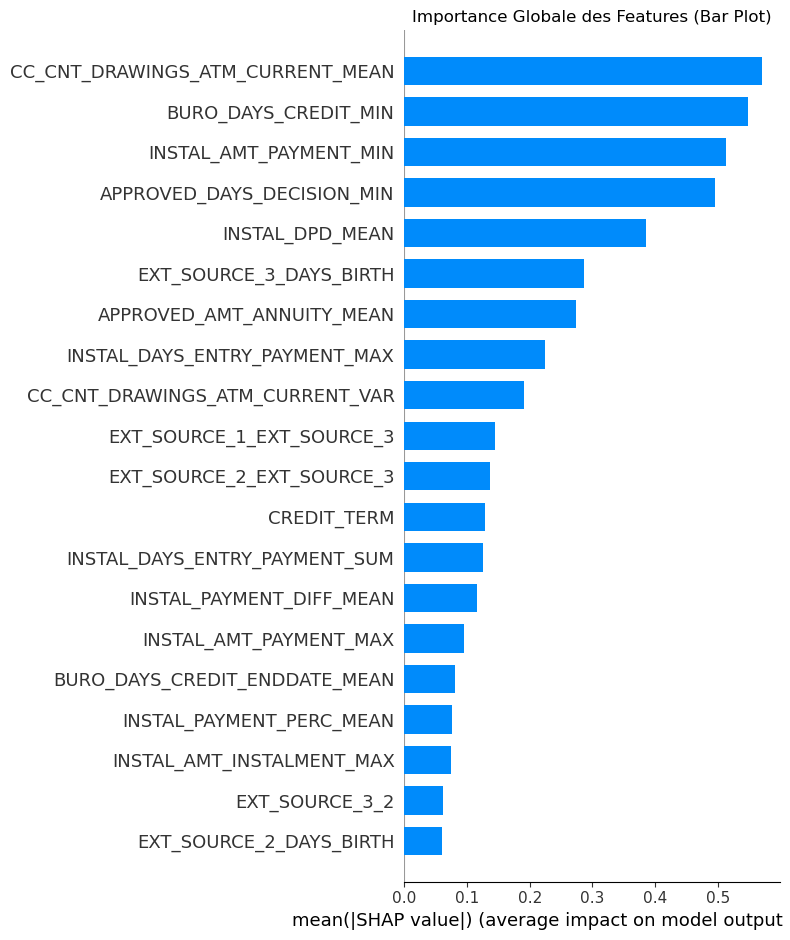

In [82]:
# Summary plot de type bar
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
plt.title("Importance Globale des Features (Bar Plot)")
plt.tight_layout()

# Sauvegarde avec plt.gcf()
fig_bar = plt.gcf()
fig_bar.savefig("global_importance_bar.png")
plt.show()

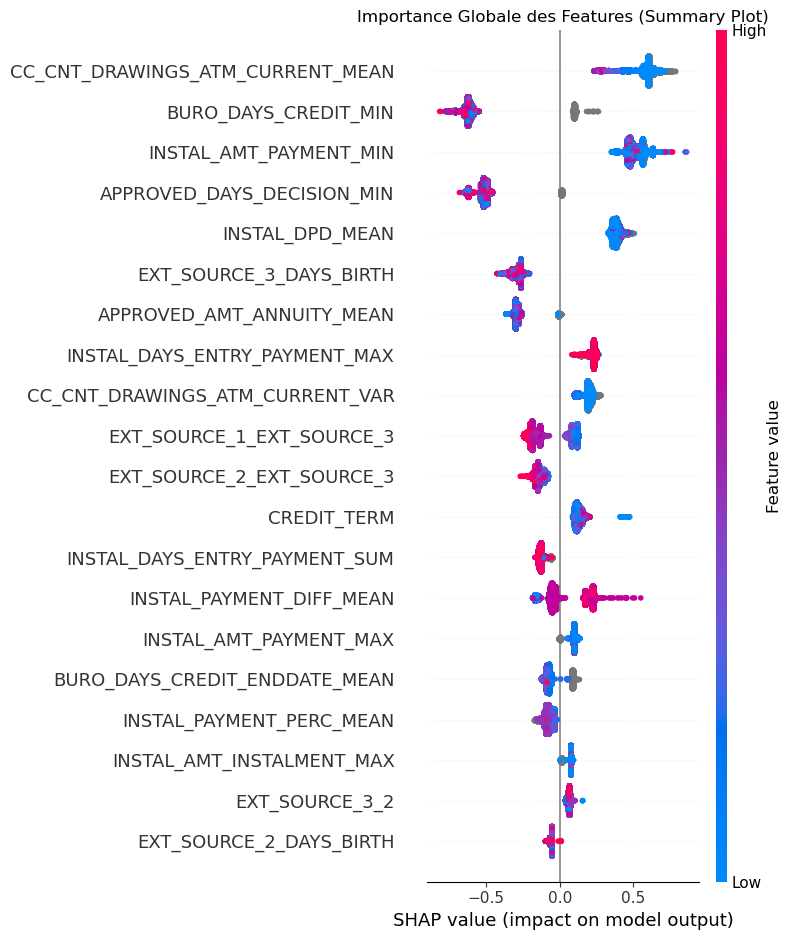

In [83]:
# Affichage du summary plot classique (scatter plot SHAP)
shap.summary_plot(shap_values, X_test, show=False)
plt.title("Importance Globale des Features (Summary Plot)")
plt.tight_layout()

# Sauvegarde avec plt.gcf()
fig_summary = plt.gcf()
fig_summary.savefig("global_importance_summary.png")
plt.show()

In [84]:
# Enregistrement des artefacts MLflow
mlflow.log_artifact("global_importance_bar.png", artifact_path="artifacts")
mlflow.log_artifact("global_importance_summary.png", artifact_path="artifacts")
mlflow.log_artifact("roc_curve.png", artifact_path="artifacts")

print("Tous les artefacts sont enregistr√©s correctement dans MLflow.")

Tous les artefacts sont enregistr√©s correctement dans MLflow.


## 7.4 Analyse locale de l'importance des variables

Afin d‚Äôanalyser comment le mod√®le prend une d√©cision sp√©cifique, nous visualisons les contributions locales des variables pour quelques exemples individuels du jeu de test (ici, 10 exemples).

In [85]:
# S√©lection d'un sous-√©chantillon de 10 lignes
sample_data = X_test.iloc[:10, :] if isinstance(X_test, pd.DataFrame) else X_test[:10, :]

# Calcul des valeurs SHAP pour l'√©chantillon
shap_values_sample = explainer(sample_data)

# Dossier temporaire pour stocker les graphiques
os.makedirs("shap_plots", exist_ok=True)

üîπ Waterfall plot pour l'√©chantillon 1 :


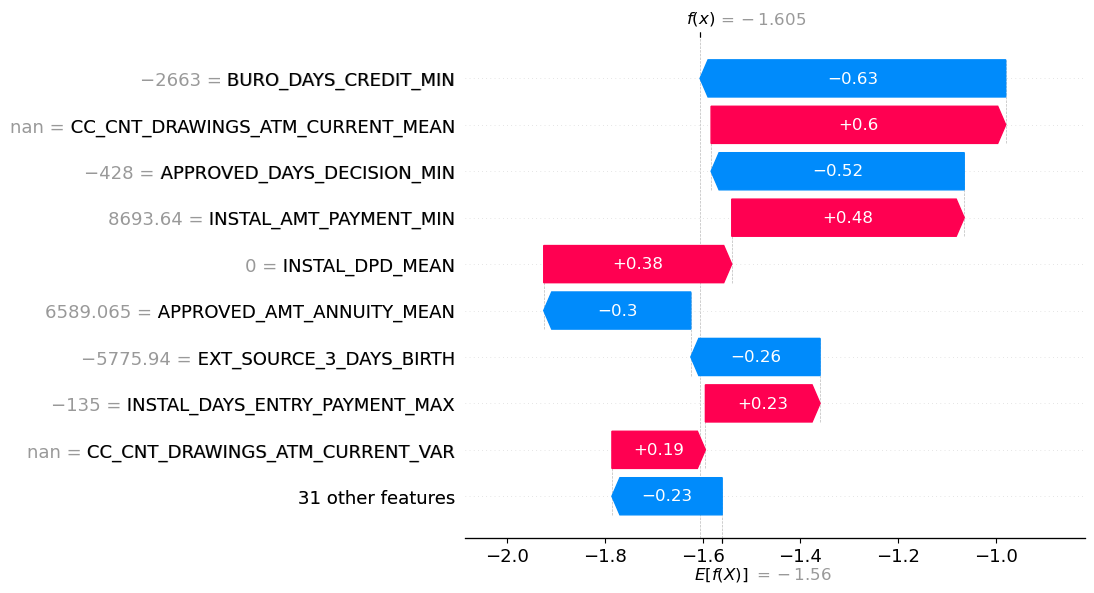

üîπ Waterfall plot pour l'√©chantillon 2 :


<Figure size 640x480 with 0 Axes>

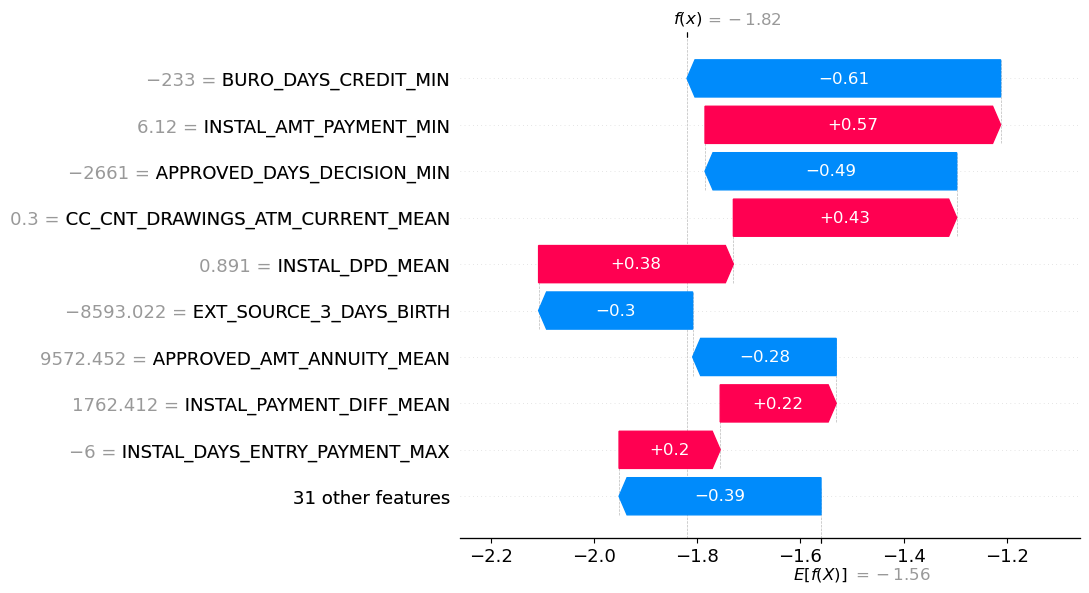

üîπ Waterfall plot pour l'√©chantillon 3 :


<Figure size 640x480 with 0 Axes>

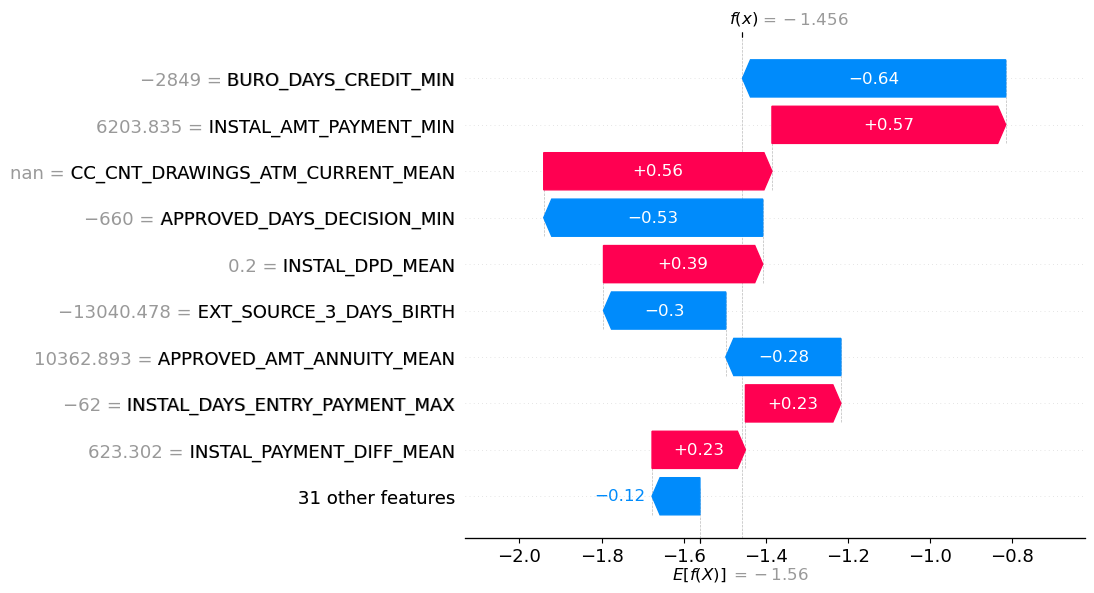

üîπ Waterfall plot pour l'√©chantillon 4 :


<Figure size 640x480 with 0 Axes>

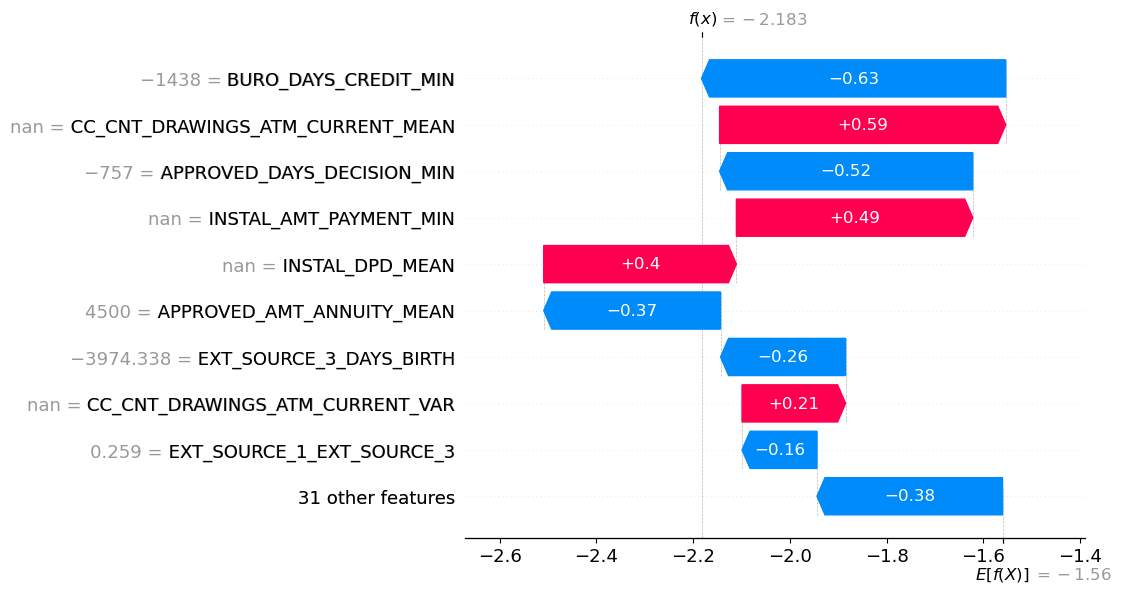

üîπ Waterfall plot pour l'√©chantillon 5 :


<Figure size 640x480 with 0 Axes>

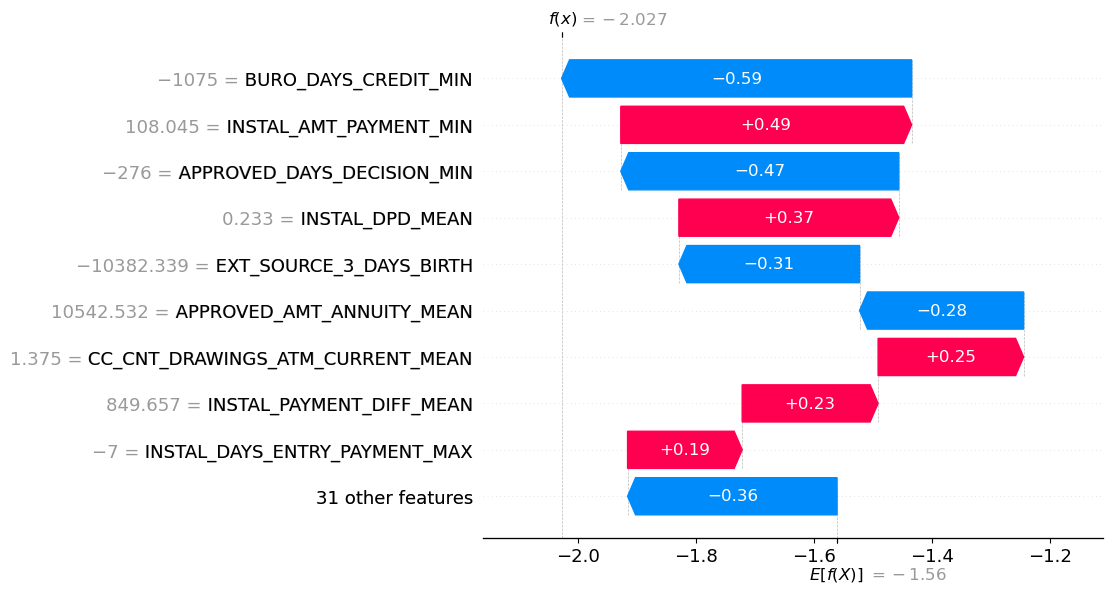

üîπ Waterfall plot pour l'√©chantillon 6 :


<Figure size 640x480 with 0 Axes>

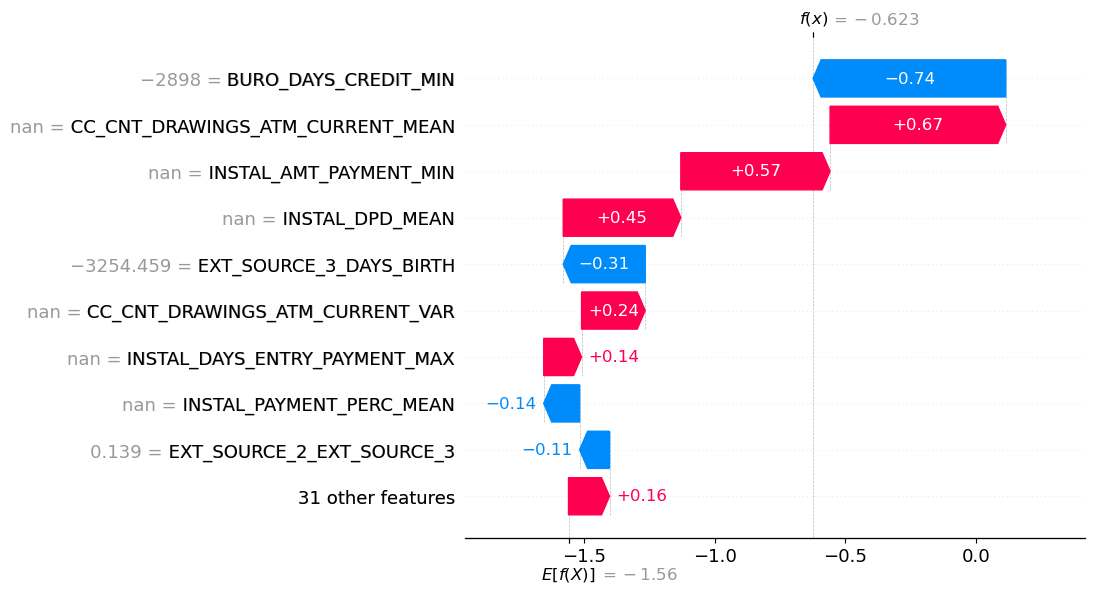

üîπ Waterfall plot pour l'√©chantillon 7 :


<Figure size 640x480 with 0 Axes>

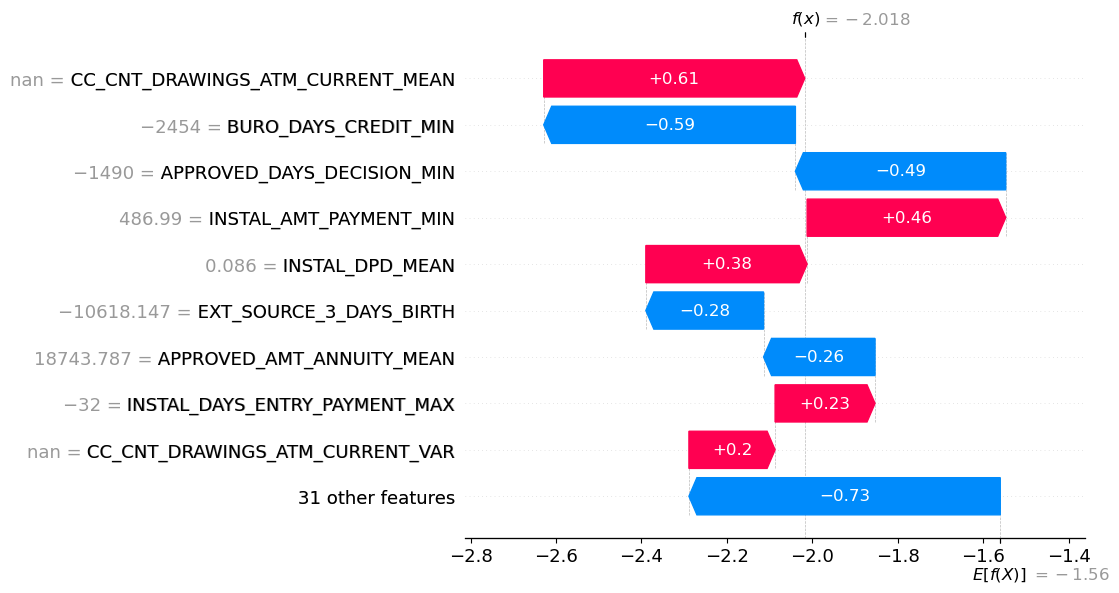

üîπ Waterfall plot pour l'√©chantillon 8 :


<Figure size 640x480 with 0 Axes>

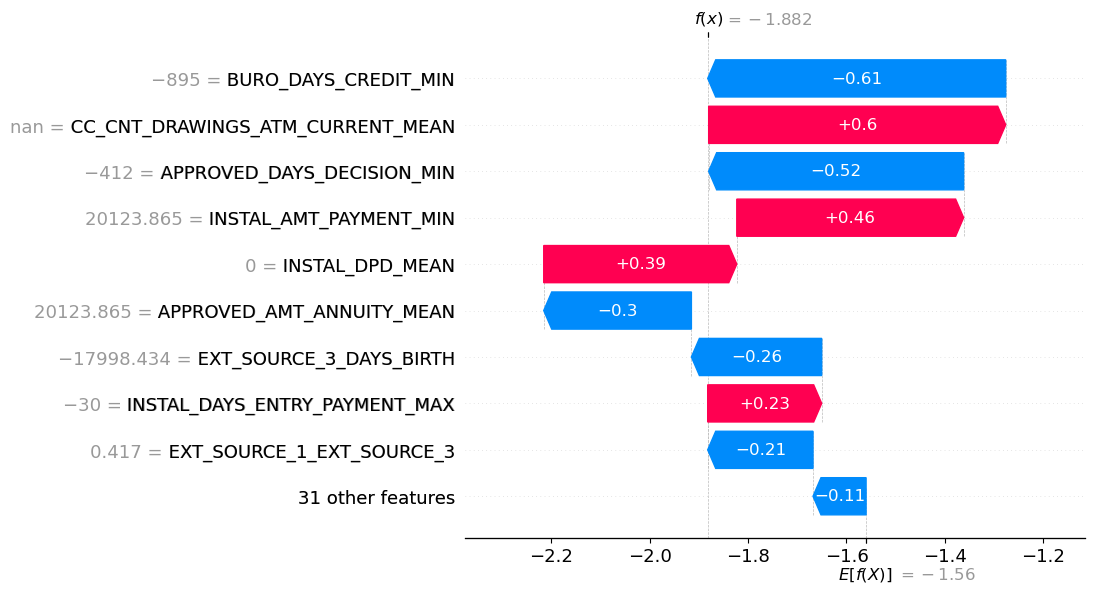

üîπ Waterfall plot pour l'√©chantillon 9 :


<Figure size 640x480 with 0 Axes>

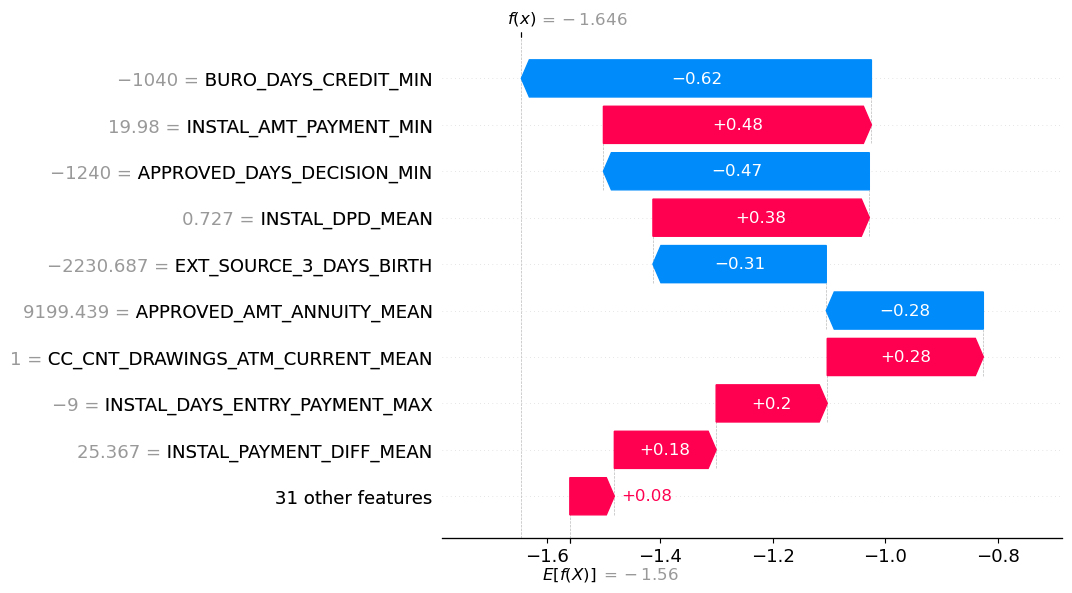

üîπ Waterfall plot pour l'√©chantillon 10 :


<Figure size 640x480 with 0 Axes>

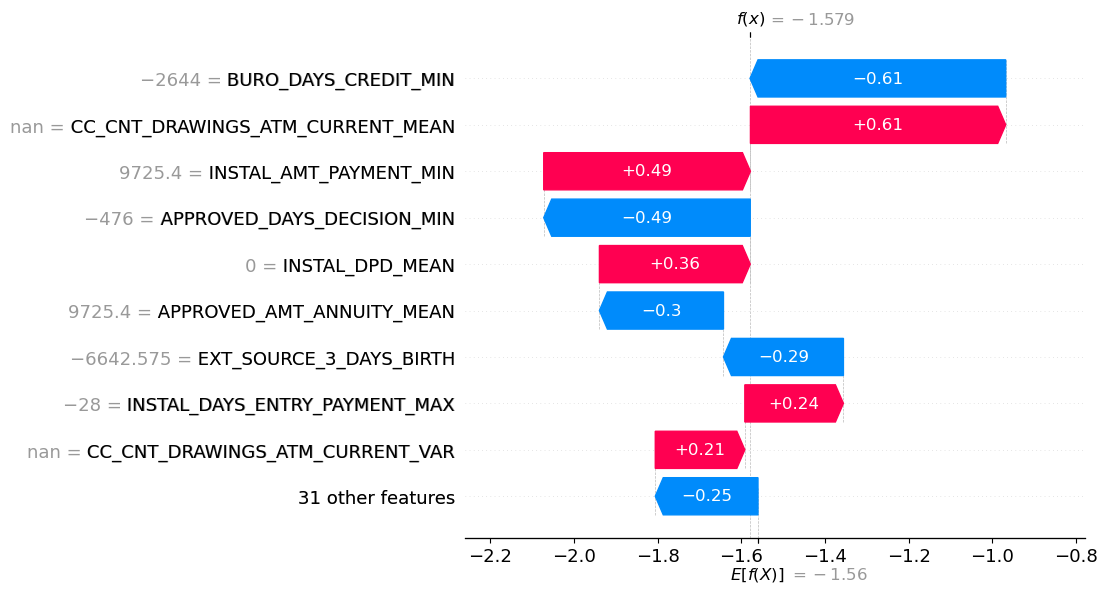

Tous les Waterfall plots ont √©t√© affich√©s et enregistr√©s dans MLflow.


<Figure size 640x480 with 0 Axes>

In [86]:
# G√©n√©ration, sauvegarde et enregistrement des waterfall plots individuels dans MLflow
for i in range(len(sample_data)):
    file_path = f"shap_plots/waterfall_{i}.png"

    print(f"üîπ Waterfall plot pour l'√©chantillon {i+1} :")

    # Cr√©ation du waterfall plot SHAP
    plt.figure()  # Nouvelle figure pour √©viter les conflits
    shap.plots.waterfall(shap_values_sample[i], show=True)  

    # Sauvegarde du graphique
    plt.savefig(file_path, bbox_inches='tight', dpi=300)

    #  Enregistrement de l‚Äôimage dans MLflow
    mlflow.log_artifact(file_path)

# Confirmation
print("Tous les Waterfall plots ont √©t√© affich√©s et enregistr√©s dans MLflow.")

## 7.5 R√©duction du nombre de features

### Selection des features

In [87]:
# Calcul de l'importance moyenne absolue
mean_abs_shap = np.abs(shap_values).mean(axis=0)
feature_importance = pd.DataFrame({
    'feature': X_test.columns,
    'importance': mean_abs_shap
}).sort_values(by='importance', ascending=False)

In [88]:
# Selection des 20 features les plus importantes
top_20_features = feature_importance['feature'].head(20).tolist()

In [89]:
print("Top 20 features les plus importantes :")
for i, feat in enumerate(top_20_features, 1):
    print(f"{i}. {feat}")

Top 20 features les plus importantes :
1. CC_CNT_DRAWINGS_ATM_CURRENT_MEAN
2. BURO_DAYS_CREDIT_MIN
3. INSTAL_AMT_PAYMENT_MIN
4. APPROVED_DAYS_DECISION_MIN
5. INSTAL_DPD_MEAN
6. EXT_SOURCE_3_DAYS_BIRTH
7. APPROVED_AMT_ANNUITY_MEAN
8. INSTAL_DAYS_ENTRY_PAYMENT_MAX
9. CC_CNT_DRAWINGS_ATM_CURRENT_VAR
10. EXT_SOURCE_1_EXT_SOURCE_3
11. EXT_SOURCE_2_EXT_SOURCE_3
12. CREDIT_TERM
13. INSTAL_DAYS_ENTRY_PAYMENT_SUM
14. INSTAL_PAYMENT_DIFF_MEAN
15. INSTAL_AMT_PAYMENT_MAX
16. BURO_DAYS_CREDIT_ENDDATE_MEAN
17. INSTAL_PAYMENT_PERC_MEAN
18. INSTAL_AMT_INSTALMENT_MAX
19. EXT_SOURCE_3_2
20. EXT_SOURCE_2_DAYS_BIRTH


In [90]:
# R√©duction de X_train et X_test
X_train_reduced = X_train[top_20_features].copy()
X_test_reduced = X_test[top_20_features].copy()

### D√©tection des types de colonnes parmi les 20 features

In [91]:
binary_cols_20 = [col for col in X_train_reduced.columns if set(X_train_reduced[col].dropna().unique()).issubset({0, 1})]
numeric_cols_20 = [col for col in X_train_reduced.columns if col not in binary_cols_20]

### Preprocessing adapt√© aux 20 features

In [92]:
preprocessor_20 = ColumnTransformer([
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]), numeric_cols_20),
    ('bin', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent'))
    ]), binary_cols_20)
])

### Cr√©ation du pipeline avec le mod√®le optimis√©

In [93]:
if best_model_name == "LightGBM":
    model_20 = LGBMClassifier(**best_params, random_state=42, verbosity=-1)
elif best_model_name == "RandomForest":
    model_20 = RandomForestClassifier(**best_params, random_state=42)
elif best_model_name == "XGBoost":
    model_20 = XGBClassifier(**best_params, use_label_encoder=False, eval_metric="logloss", random_state=42)

pipeline_20 = ImbPipeline([
    ('preprocessor', preprocessor_20),
    ('smote', SMOTE(sampling_strategy=0.3, random_state=42)),
    ('model', model_20)
])

### Entra√Ænement du mod√®le

In [94]:
pipeline_20.fit(X_train_reduced, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['CC_CNT_DRAWINGS_ATM_CURRENT_MEAN',
                                                   'BURO_DAYS_CREDIT_MIN',
                                                   'INSTAL_AMT_PAYMENT_MIN',
                                                   'APPROVED_DAYS_DECISION_MIN',
                                                   'INSTAL_DPD_MEAN',
                                                   'EXT_SOURCE_3_DAYS_BIRTH',
                                                   'APPROVED_AMT_ANNUITY_MEAN',
                                                   'IN...
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  [])])),
                ('smote', SMOTE(random_state=42, sampling_strategy=0.3)),
                ('model',
                 LGBMClassifier(colsample_bytree=0.7952362719480109,
                                learning_rate=0.04448339222627268,
                                n_estimators=290, num_leaves=13,
                                random_state=42,
                                reg_alpha=4.272661901360118e-06,
                                reg_lambda=7.390301467885012e-09,
                                subsample=0.6853774227855893, verbosity=-1))])

### Pr√©dictions sur X_test r√©duit

In [95]:
y_proba_test_20 = pipeline_20.predict_proba(X_test_reduced)[:, 1]
best_threshold_20, cost_20 = find_optimal_threshold(y_test, y_proba_test_20)
y_pred_test_20 = (y_proba_test_20 >= best_threshold_20).astype(int)

### √âvaluation

In [96]:
auc_20 = roc_auc_score(y_test, y_proba_test_20)
f1_20 = f1_score(y_test, y_pred_test_20)
precision_20 = precision_score(y_test, y_pred_test_20)
recall_20 = recall_score(y_test, y_pred_test_20)

### Affichage des r√©sultats

In [104]:
print("\n R√©sultats mod√®le initial (toutes features) avant HyperOpt :")
print(f"AUC : {test_auc:.4f} | F1 : {test_f1:.4f} | Co√ªt : {optimal_cost:.2f}")
print(f"Seuil optimal : {best_threshold:.2f}")

print("\n R√©sultats mod√®le r√©duit (20 features SHAP) :")
print(f"AUC : {auc_20:.4f} | F1 : {f1_20:.4f} | Co√ªt : {cost_20:.2f}")
print(f"Seuil optimal : {best_threshold_20:.2f}")


 R√©sultats mod√®le initial (toutes features) avant HyperOpt :
AUC : 0.7280 | F1 : 0.2541 | Co√ªt : 35035.00
Seuil optimal : 0.39

 R√©sultats mod√®le r√©duit (20 features SHAP) :
AUC : 0.7277 | F1 : 0.2482 | Co√ªt : 35011.00
Seuil optimal : 0.18


## 7.6 Enregistrement du mod√®le r√©duit √† 20 features

### Sauvegarde en Joblib

In [98]:
joblib.dump(pipeline_20, "best_model_20_features.joblib")
print("üì¶ Mod√®le all√©g√© sauvegard√© : best_model_20_features.joblib")

üì¶ Mod√®le all√©g√© sauvegard√© : best_model_20_features.joblib


### Enregistrement dans MLflow

In [99]:
# S'assurer qu'aucun run n'est encore actif
if mlflow.active_run():
    mlflow.end_run()

try:
    with mlflow.start_run(run_name="Model_20_Features"):
        signature_20 = infer_signature(X_test_reduced, pipeline_20.predict(X_test_reduced))
        input_example_20 = X_test_reduced.iloc[:5]

        mlflow.sklearn.log_model(
            sk_model=pipeline_20,
            artifact_path="models/model_20_features",
            input_example=input_example_20,
            signature=signature_20
        )

        # Log des m√©triques
        mlflow.log_metric("Test AUC", auc_20)
        mlflow.log_metric("Test F1 Score", f1_20)
        mlflow.log_metric("Test Precision", precision_20)
        mlflow.log_metric("Test Recall", recall_20)
        mlflow.log_metric("Test Business Cost", cost_20)
        mlflow.log_metric("Optimal Threshold", best_threshold_20)

        print("Mod√®le 20 features + m√©triques enregistr√©s dans MLflow")

except Exception as e:
    print(f"Erreur lors de l'enregistrement dans MLflow : {e}")

Mod√®le 20 features + m√©triques enregistr√©s dans MLflow


## 8. Lancement et consultation du tableau de bord MLflow

Pour visualiser les r√©sultats d√©taill√©s de nos exp√©riences et suivre pr√©cis√©ment les performances des mod√®les entra√Æn√©s, nous utilisons le tableau de bord MLflow (MLflow UI).
Le script suivant v√©rifie que MLflow est install√©, d√©marre automatiquement l'interface utilisateur MLflow si elle n'est pas d√©j√† en cours d'ex√©cution, et permet d'acc√©der directement √† l'interface via un lien local.

In [100]:
# V√©rifier si MLflow est install√©
try:
    subprocess.run(["mlflow", "--version"], check=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True, encoding="cp1252")
except FileNotFoundError:
    print("MLflow n'est pas install√© ou n'est pas accessible depuis l'environnement.")
    print("Installe-le avec : `pip install mlflow`")
    raise SystemExit

# V√©rifier si un serveur MLflow tourne d√©j√†
try:
    process = subprocess.run(["tasklist"], capture_output=True, text=True, encoding="cp1252")
    if "mlflow.exe" in process.stdout:
        print("Un serveur MLflow tourne d√©j√†. Ouvre-le ici : http://127.0.0.1:5000")
    else:
        # D√©marrer MLflow UI en arri√®re-plan
        mlflow_ui_process = subprocess.Popen(["mlflow", "ui", "--backend-store-uri", "file:///C:/Users/guigo/Documents/FORMATION/Alternance/Projet 7/mlruns", "--port", "5000"],
    stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True, encoding="cp1252"
)
        time.sleep(5)  # Attendre quelques secondes pour √©viter les erreurs

        print("MLflow UI est en cours d'ex√©cution.")
        display(HTML('<a href="http://127.0.0.1:5000" target="_blank">Ouvrir MLflow UI</a>'))

except Exception as e:
    print(f"Erreur lors du lancement de MLflow UI : {e}")

MLflow n'est pas install√© ou n'est pas accessible depuis l'environnement.
Installe-le avec : `pip install mlflow`


SystemExit: 

In [ ]:
# Dans le terminal pour lancer l'API
#mlflow ui --backend-store-uri "file:///C:/Users/guigo/Documents/FORMATION/Alternance/Projet 7/mlruns"